# Union Hill Enslaved Data Preparation

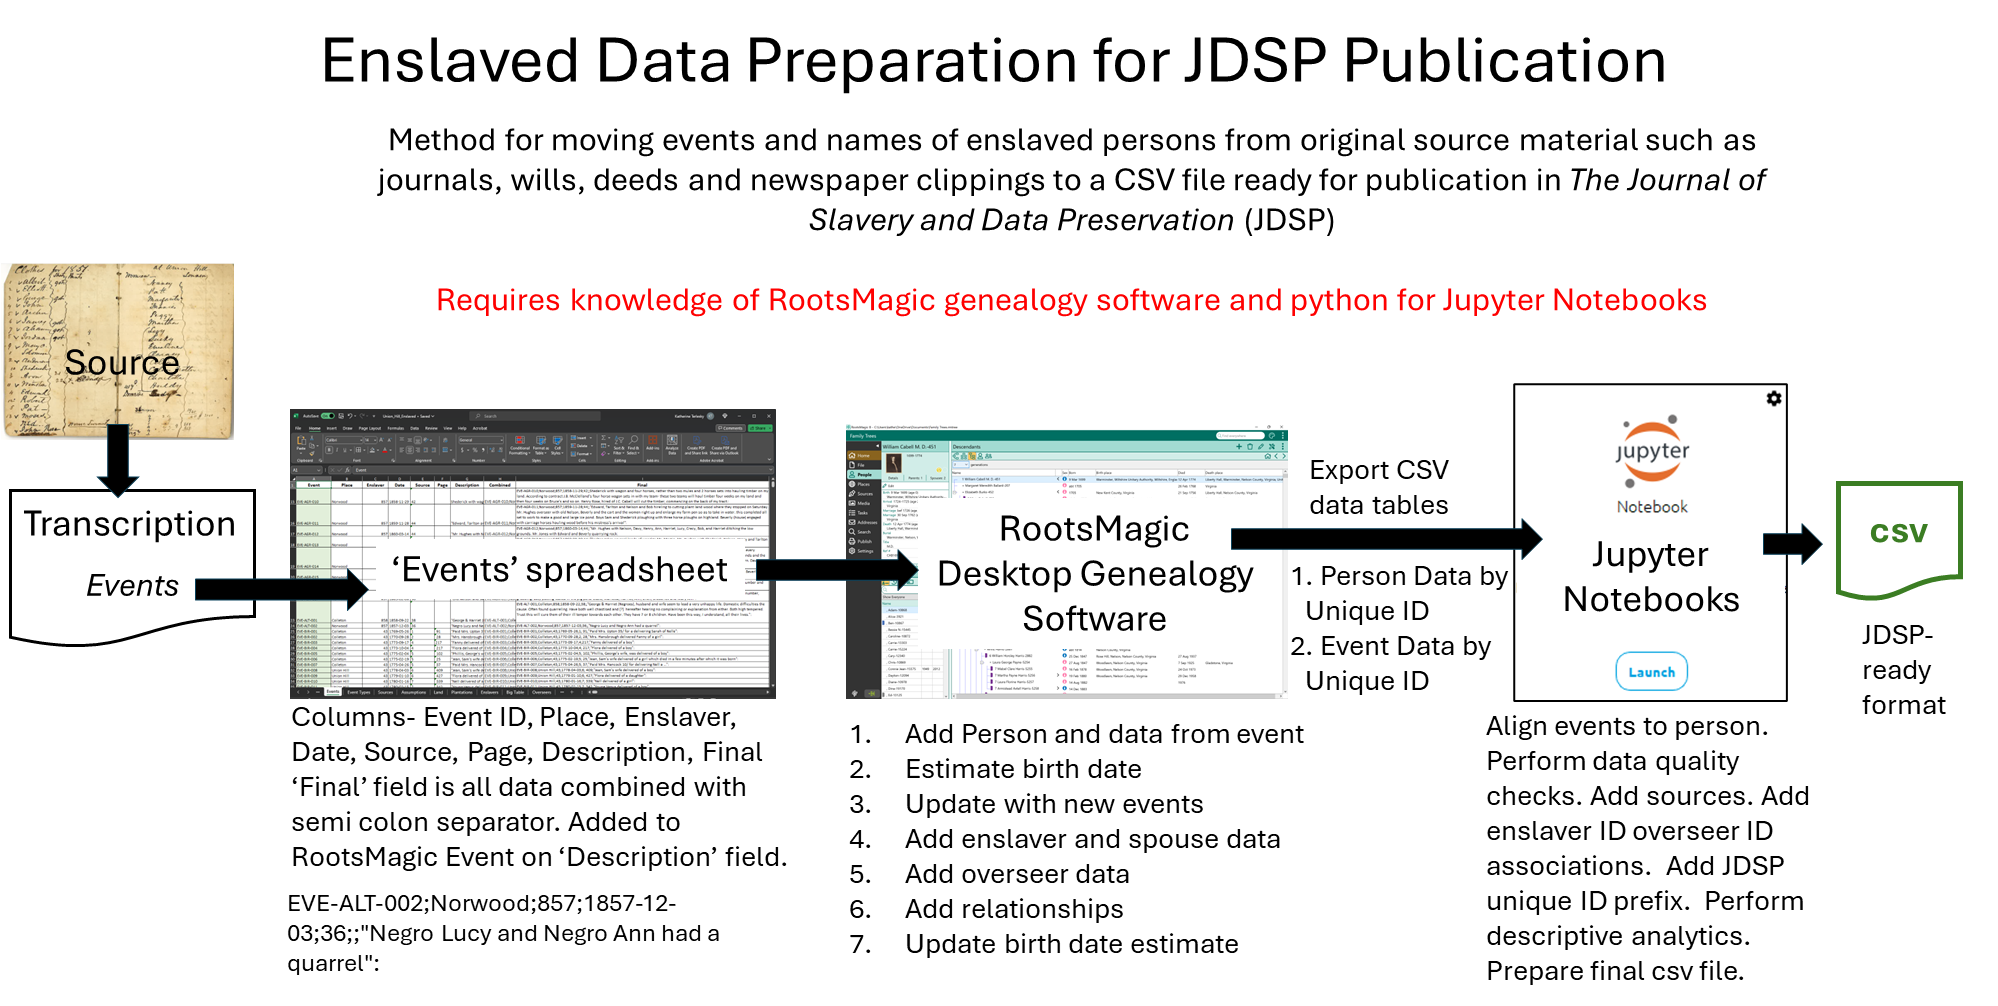

In [1]:
from IPython import display
display.Image(filename="Methodology.png", width=1000, height=1000)

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests

import plotly.express as px
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import rcParams
import matplotlib.animation as animation


#import datetime module
import datetime

print('Libraries imported.')

Libraries imported.


## Common Functions

In [3]:
#Trim whitespace from ends of each value across all series in dataframe
def trim_all_columns(df):
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.map(trim_strings)

# Overview of Steps in this Notebook

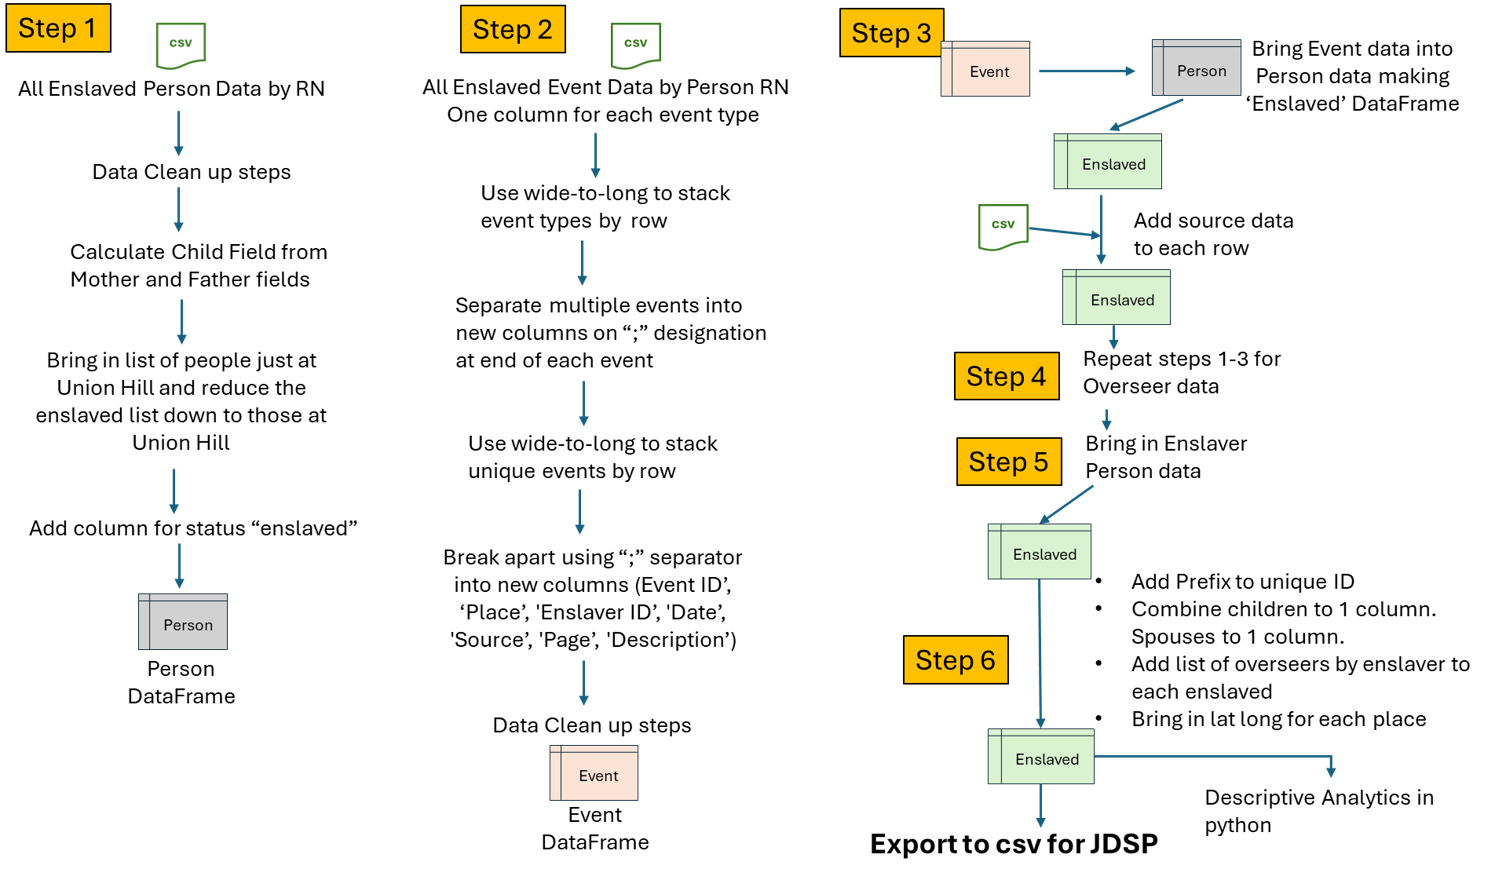

In [4]:
display.Image(filename="PythonSteps.png", width=1000, height=1000)

## STEP 1

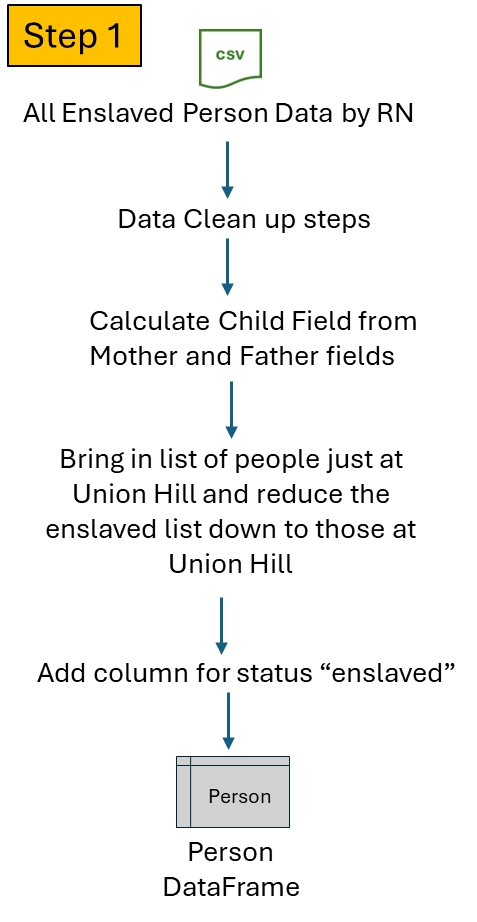

In [5]:
display.Image(filename="FirstStep.png", width=250, height=400)

### Enslaved Person Data by RN (Record Number)

In [6]:
#import the Masterfile CSV to work with and a column for "order"
file = "EnslavedPersonData_01182024.csv"
person = pd.read_csv(file)
person = trim_all_columns(person)
person = person.rename(columns={'Nickname':'Alternate Name', 'Birthdate':'Birth date', 'Deathdate':'Death date'})
person = person.replace(to_replace='[Unknown] [Unknown]-0', value=np.NaN)
print(person.shape)
person.head()

(626, 10)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse
0,708,Abby,NaN,NaN,F,abt 1793,NaN,NaN,NaN,NaN
1,639,Abel,NaN,NaN,M,bef 1773,NaN,NaN,NaN,NaN
2,199,Abraham,NaN,NaN,M,1796,NaN,NaN,Lett -86,NaN
3,620,Abraham,NaN,NaN,M,abt 1797,NaN,NaN,"Kate ""Cate"" -152",NaN
4,1035,Abraham,NaN,NaN,M,bef 1798,NaN,NaN,Esther -1037,NaN


### Data Clean Up Steps

In [7]:
# Remove names from Spouse and Parents - just Keep RN
person['Spouse'] = person['Spouse'].replace(regex=[r'\D+'], value="")#.astype(str)
person['Father'] = person['Father'].replace(regex=[r'\D+'], value="")#.astype(str)
person['Mother'] = person['Mother'].replace(regex=[r'\D+'], value="")#.astype(str)
person = person.sort_values('Mother')
person.head(10)

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse
174,97,George,NaN,NaN,M,bef 1762,NaN,14,1,2
265,121,Joshua,NaN,NaN,M,bef 1765,NaN,14,1,NaN
511,102,Unknown,Molly's girl,NaN,F,29 Dec 1795,NaN,NaN,101,NaN
4,1035,Abraham,NaN,NaN,M,bef 1798,NaN,NaN,1037,NaN
553,1070,Sarah,NaN,Banks,F,1831,NaN,1065,1067,NaN
549,1071,Lavinia,Laura,Banks,F,1832,NaN,1065,1067,NaN
548,1075,Henry,NaN,Banks,M,1820,NaN,1065,1067,NaN
550,1072,Margaret,NaN,Banks,F,1835,NaN,1065,1067,NaN
547,1069,Eveline,NaN,Banks,F,1830,NaN,1065,1067,NaN
545,1074,Daniel,NaN,Banks,M,1837,NaN,1065,1067,NaN


In [8]:
person[person['RN']==115]

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse
469,115,Tandy,NaN,NaN,M,bef 1776,NaN,NaN,NaN,NaN


### Calculate Child Field from Mother and Father

In [9]:
#create dataframe of Mothers
df = person[['Mother','RN']]
df = df.dropna().sort_values(['Mother','RN'])
print(df.shape)
df.head()

(172, 2)


,Mother,RN
174,1,97
265,1,121
511,101,102
4,1037,1035
543,1067,1068


In [10]:
df['count'] = df.groupby('Mother').cumcount()
df['order'] = df['RN']
df.head(30)

,Mother,RN,count,order
174,1,97,0,97
265,1,121,1,121
511,101,102,0,102
4,1037,1035,0,1035
543,1067,1068,0,1068
547,1067,1069,1,1069
553,1067,1070,2,1070
549,1067,1071,3,1071
550,1067,1072,4,1072
544,1067,1073,5,1073


In [11]:
df = df.sort_values(['Mother','count'])
df.head(20)

,Mother,RN,count,order
174,1,97,0,97
265,1,121,1,121
511,101,102,0,102
4,1037,1035,0,1035
543,1067,1068,0,1068
547,1067,1069,1,1069
553,1067,1070,2,1070
549,1067,1071,3,1071
550,1067,1072,4,1072
544,1067,1073,5,1073


In [12]:
df = df.pivot(index=['Mother','order'], columns='count', values='RN')
df.head(20)

count              0       1       2       3       4       5       6       7
Mother order                                                                
1      97       97.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       121       NaN   121.0     NaN     NaN     NaN     NaN     NaN     NaN
101    102     102.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1037   1035   1035.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1067   1068   1068.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1069      NaN  1069.0     NaN     NaN     NaN     NaN     NaN     NaN
       1070      NaN     NaN  1070.0     NaN     NaN     NaN     NaN     NaN
       1071      NaN     NaN     NaN  1071.0     NaN     NaN     NaN     NaN
       1072      NaN     NaN     NaN     NaN  1072.0     NaN     NaN     NaN
       1073      NaN     NaN     NaN     NaN     NaN  1073.0     NaN     NaN
       1074      NaN     NaN     NaN     NaN     NaN     NaN  1074.0     NaN
       1075      NaN     NaN     NaN     NaN     NaN     NaN     NaN  1075.0
1076   1077   1077.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1080   1081   1081.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1082      NaN  1082.0     NaN     NaN     NaN     NaN     NaN     NaN
1084   1085   1085.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1089   1090   1090.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1091      NaN  1091.0     NaN     NaN     NaN     NaN     NaN     NaN
1093   1094   1094.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1095      NaN  1095.0     NaN     NaN     NaN     NaN     NaN     NaN

In [13]:
df[1] = df[1].shift(periods=-1)
df[2] = df[2].shift(periods=-2)
df[3] = df[3].shift(periods=-3)
df[4] = df[4].shift(periods=-4)
df[5] = df[5].shift(periods=-5)
df[6] = df[6].shift(periods=-6)
df[7] = df[7].shift(periods=-7)
print(df.shape)
df.head(25)

(172, 8)


count              0       1       2       3       4       5       6       7
Mother order                                                                
1      97       97.0   121.0     NaN     NaN     NaN     NaN     NaN     NaN
       121       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
101    102     102.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1037   1035   1035.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1067   1068   1068.0  1069.0  1070.0  1071.0  1072.0  1073.0  1074.0  1075.0
       1069      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1070      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1071      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1072      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1073      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1074      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1075      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1076   1077   1077.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1080   1081   1081.0  1082.0     NaN     NaN     NaN     NaN     NaN     NaN
       1082      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1084   1085   1085.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1089   1090   1090.0  1091.0     NaN     NaN     NaN     NaN     NaN     NaN
       1091      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1093   1094   1094.0  1095.0     NaN     NaN     NaN     NaN     NaN     NaN
       1095      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1097   1098   1098.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1101   1102   1102.0  1103.0  1104.0  1105.0  1106.0  1107.0     NaN     NaN
       1103      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1104      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1105      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN

In [14]:
df =df.reset_index(level=1,drop=True).reset_index().dropna(subset=[0])
df.head()

count,Mother,0,1,2,3,4,5,6,7
0,1,97.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN
2,101,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1037,1035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1067,1068.0,1069.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0
12,1076,1077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df =df.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8','Mother':'RN'})
df = df.replace(to_replace=np.NaN, value=0)
df =df.astype(int)
print(df.shape)
df.head()

(75, 9)


count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
0,1,97,121,0,0,0,0,0,0
2,101,102,0,0,0,0,0,0,0
3,1037,1035,0,0,0,0,0,0,0
4,1067,1068,1069,1070,1071,1072,1073,1074,1075
12,1076,1077,0,0,0,0,0,0,0


## Repeat for Father and children

In [16]:
#create dataframe of Fathers
dff = person[['Father','RN']]
dff = dff.dropna().sort_values(['Father','RN'])
print(dff.shape)
dff['count'] = dff.groupby('Father').cumcount()
dff['order'] = dff['RN']
dff = dff.sort_values(['Father','count'])
dff = dff.pivot(index=['Father','order'], columns='count', values='RN')
print(dff.shape)
dff

(99, 2)
(99, 8)


count              0       1       2       3       4       5       6       7
Father order                                                                
1065   1068   1068.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1069      NaN  1069.0     NaN     NaN     NaN     NaN     NaN     NaN
       1070      NaN     NaN  1070.0     NaN     NaN     NaN     NaN     NaN
       1071      NaN     NaN     NaN  1071.0     NaN     NaN     NaN     NaN
       1072      NaN     NaN     NaN     NaN  1072.0     NaN     NaN     NaN
       1073      NaN     NaN     NaN     NaN     NaN  1073.0     NaN     NaN
       1074      NaN     NaN     NaN     NaN     NaN     NaN  1074.0     NaN
       1075      NaN     NaN     NaN     NaN     NaN     NaN     NaN  1075.0
1079   1081   1081.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1082      NaN  1082.0     NaN     NaN     NaN     NaN     NaN     NaN
1092   1094   1094.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1095      NaN  1095.0     NaN     NaN     NaN     NaN     NaN     NaN
1096   1098   1098.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1100   1102   1102.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1103      NaN  1103.0     NaN     NaN     NaN     NaN     NaN     NaN
       1104      NaN     NaN  1104.0     NaN     NaN     NaN     NaN     NaN
       1105      NaN     NaN     NaN  1105.0     NaN     NaN     NaN     NaN
       1106      NaN     NaN     NaN     NaN  1106.0     NaN     NaN     NaN
       1107      NaN     NaN     NaN     NaN     NaN  1107.0     NaN     NaN
1108   1110   1110.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1111      NaN  1111.0     NaN     NaN     NaN     NaN     NaN     NaN
       1112      NaN     NaN  1112.0     NaN     NaN     NaN     NaN     NaN
       1113      NaN     NaN     NaN  1113.0     NaN     NaN     NaN     NaN
1114   1115   1115.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1116      NaN  1116.0     NaN     NaN     NaN     NaN     NaN     NaN
       1117      NaN     NaN  1117.0     NaN     NaN     NaN     NaN     NaN
1140   1142   1142.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       1143      NaN  1143.0     NaN     NaN     NaN     NaN     NaN     NaN
       1144      NaN     NaN  1144.0     NaN     NaN     NaN     NaN     NaN
       1145      NaN     NaN     NaN  1145.0     NaN     NaN     NaN     NaN
       1146      NaN     NaN     NaN     NaN  1146.0     NaN     NaN     NaN
136    193     193.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
14     97       97.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       121       NaN   121.0     NaN     NaN     NaN     NaN     NaN     NaN
163    756     756.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
196    812     812.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       820       NaN   820.0     NaN     NaN     NaN     NaN     NaN     NaN
       823       NaN     NaN   823.0     NaN     NaN     NaN     NaN     NaN
       849       NaN     NaN     NaN   849.0     NaN     NaN     NaN     NaN
25     35       35.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       60        NaN    60.0     NaN     NaN     NaN     NaN     NaN     NaN
       80        NaN     NaN    80.0     NaN     NaN     NaN     NaN     NaN
312    809     809.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       839       NaN   839.0     NaN     NaN     NaN     NaN     NaN     NaN
320    804     804.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
       884       NaN   884.0     NaN     NaN     NaN     NaN     NaN     NaN
       885       NaN     NaN   885.0     NaN     NaN     NaN     NaN     NaN
       935       NaN     NaN     NaN   935.0     NaN     NaN     NaN     NaN
       943       NaN     NaN     NaN     NaN   943.0     NaN     NaN     NaN
       944       NaN     NaN     NaN     NaN     NaN   944.0     NaN     

In [17]:
dff[1] = dff[1].shift(periods=-1)
dff[2] = dff[2].shift(periods=-2)
dff[3] = dff[3].shift(periods=-3)
dff[4] = dff[4].shift(periods=-4)
dff[5] = dff[5].shift(periods=-5)
dff[6] = dff[6].shift(periods=-6)
dff[7] = dff[7].shift(periods=-7)

dff =dff.reset_index(level=1,drop=True).reset_index().dropna(subset=[0])

print(dff.shape)
dff.head()

(33, 9)


count,Father,0,1,2,3,4,5,6,7
0,1065,1068.0,1069.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0
8,1079,1081.0,1082.0,NaN,NaN,NaN,NaN,NaN,NaN
10,1092,1094.0,1095.0,NaN,NaN,NaN,NaN,NaN,NaN
12,1096,1098.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1100,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,NaN,NaN


In [18]:
dff =dff.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8','Father':'RN'})
dff = dff.replace(to_replace=np.NaN, value=0)
dff =dff.astype(int)
dff.head()

count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
0,1065,1068,1069,1070,1071,1072,1073,1074,1075
8,1079,1081,1082,0,0,0,0,0,0
10,1092,1094,1095,0,0,0,0,0,0
12,1096,1098,0,0,0,0,0,0,0
13,1100,1102,1103,1104,1105,1106,1107,0,0


### Concatenate Join Mother and Father together

In [19]:
children = pd.concat([df,dff])
print(children.shape)
children.head(20)

(108, 9)


count,RN,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
0,1,97,121,0,0,0,0,0,0
2,101,102,0,0,0,0,0,0,0
3,1037,1035,0,0,0,0,0,0,0
4,1067,1068,1069,1070,1071,1072,1073,1074,1075
12,1076,1077,0,0,0,0,0,0,0
13,1080,1081,1082,0,0,0,0,0,0
15,1084,1085,0,0,0,0,0,0,0
16,1089,1090,1091,0,0,0,0,0,0
18,1093,1094,1095,0,0,0,0,0,0
20,1097,1098,0,0,0,0,0,0,0


In [20]:
children = children.sort_values('RN').set_index('RN')
children.head()

count,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
RN,,,,,,,,
1,97,121,0,0,0,0,0,0
2,3,98,617,618,619,0,0,0
8,36,56,57,0,0,0,0,0
14,97,121,0,0,0,0,0,0
19,36,56,57,0,0,0,0,0


### Rejoin to person Dataframe

In [21]:
person = person.sort_values('RN').set_index('RN')
person = person.join(children).reset_index()
person[['Father','Mother','Spouse','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']] =  person[['Father','Mother','Spouse','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']].replace(to_replace=np.NaN, value=0).astype(int)
print(person.shape)
person.head()

(626, 18)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
0,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0
1,2,Hannah,NaN,NaN,F,bef 1766,NaN,0,0,97,3,98,617,618,619,0,0,0
2,3,Unknown,Hannah's son,NaN,M,25 Sep 1780,NaN,97,2,0,0,0,0,0,0,0,0,0
3,4,Greenock,NaN,NaN,M,bef 1761,NaN,0,0,0,0,0,0,0,0,0,0,0
4,5,Mingo,NaN,NaN,M,abt 1760,NaN,0,0,0,0,0,0,0,0,0,0,0


In [22]:
person[person['RN']==115]

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
95,115,Tandy,NaN,NaN,M,bef 1776,NaN,0,0,0,0,0,0,0,0,0,0,0


In [23]:
person['Status'] = 'Enslaved'

## Bring in file with Union Hill Enslaved RNs (Norwood, UH, Montzuma, Colleton, Soldier's Joy, Parsonage) to narrow down enslaved dataframe

In [24]:
#import the Masterfile CSV to work with and a column for "order"
file = "UnionHill_01162024.csv"
UHill = pd.read_csv(file).drop_duplicates().sort_values('RN')
UHill = UHill["RN"].tolist()


In [25]:
person = person.sort_values('RN')
person['Location'] = 'UnionHill'
person['Location'] = person['Location'].where(person['RN'].isin(UHill),np.NaN)
print(person.shape)
person.head()


(626, 20)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Status,Location
0,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill
1,2,Hannah,NaN,NaN,F,bef 1766,NaN,0,0,97,3,98,617,618,619,0,0,0,Enslaved,UnionHill
2,3,Unknown,Hannah's son,NaN,M,25 Sep 1780,NaN,97,2,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill
3,4,Greenock,NaN,NaN,M,bef 1761,NaN,0,0,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill
4,5,Mingo,NaN,NaN,M,abt 1760,NaN,0,0,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill


In [26]:
person['Location'].value_counts()

Location
UnionHill    568
Name: count, dtype: int64

In [27]:
person = person.dropna(subset=['Location'])
print(person.shape)

(568, 20)


In [28]:
person[person['RN']==115]

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Status,Location
95,115,Tandy,NaN,NaN,M,bef 1776,NaN,0,0,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill


In [29]:
person = person.sort_values('RN').set_index('RN')
print(person.shape)
person.head()

(568, 19)


,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Status,Location
RN,,,,,,,,,,,,,,,,,,,
1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill
2,Hannah,NaN,NaN,F,bef 1766,NaN,0,0,97,3,98,617,618,619,0,0,0,Enslaved,UnionHill
3,Unknown,Hannah's son,NaN,M,25 Sep 1780,NaN,97,2,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill
4,Greenock,NaN,NaN,M,bef 1761,NaN,0,0,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill
5,Mingo,NaN,NaN,M,abt 1760,NaN,0,0,0,0,0,0,0,0,0,0,0,Enslaved,UnionHill


#### Insert column for 'Spouse2' do help concant step later on

In [30]:
person.loc[:, "Spouse2"] = "0"

## STEP 2

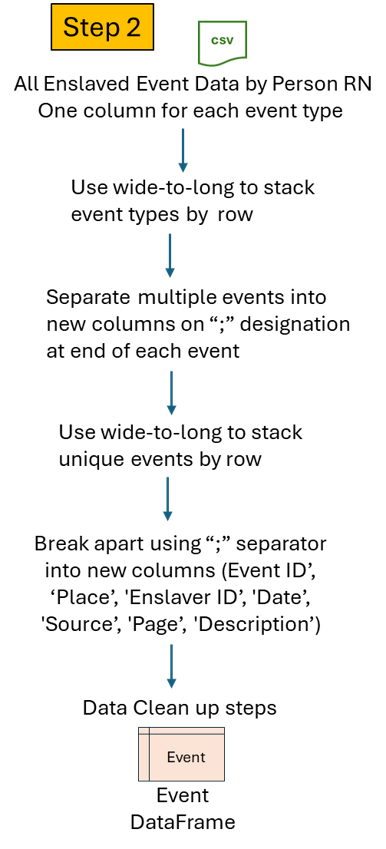

In [31]:
display.Image(filename="SecondStep.png", width=250, height=400)

## IMPORTANT- Remove all quotation marks (") before uploading file from Roots Magic

In [32]:
file = "EnslavedEventData_01192024.csv"
events = pd.read_csv(file)
events = trim_all_columns(events)

print(events.shape)
events.head()

(626, 31)


,RN,EVE-BIR,EVE-DEA,EVE-TRF,EVE-CRM,EVE-DIS,EVE-CRT,EVE-PRO,EVE-NEC,EVE-ENS,EVE-MED,EVE-RES,EVE-HIR,EVE-LAB,EVE-DOM,EVE-TRV,EVE-ADV,EVE-TAX,EVE-WILL,EVE-CRF,EVE-RET,EVE-OVR,EVE-PUN,EVE-MIL,EVE-ALT,EVE-AGR,EVE-EMN,EVE-CEN,EVE-CEM,EVE-ILL,EVE-MAR
0,708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-008;Soldier's Joy;272;1818;;;Enslaved ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-019;Soldier's Joy;272;1818;21;120;From...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-008;Soldier's Joy;272;1818;;;Enslaved ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-018;Soldier's Joy;272;1818;21;120;From...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-001;Colleton;43;1798;;;Enslaved by Wil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-001;Union Hill;43;1800;14;;Negroes at ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-ENS-011;Montezuma;271;1807;;;Enslaved by H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1035,NaN,NaN,EVE-TFR-031;Union Hill;44;1816;13;418;Changes ...,NaN,NaN,NaN,NaN,NaN,EVE-ENS-005;Union Hill;44;1810;;;Enslaved by W...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVE-TAX-007;Union Hill;44;1810;14;;Date Estima...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
events[events.RN==115]

,RN,EVE-BIR,EVE-DEA,EVE-TRF,EVE-CRM,EVE-DIS,EVE-CRT,EVE-PRO,EVE-NEC,EVE-ENS,EVE-MED,EVE-RES,EVE-HIR,EVE-LAB,EVE-DOM,EVE-TRV,EVE-ADV,EVE-TAX,EVE-WILL,EVE-CRF,EVE-RET,EVE-OVR,EVE-PUN,EVE-MIL,EVE-ALT,EVE-AGR,EVE-EMN,EVE-CEN,EVE-CEM,EVE-ILL,EVE-MAR
469,115,NaN,NaN,NaN,NaN,EVE-DIS-005;Union Hill;43;1790-04-01;8;199;Tan...,NaN,NaN,NaN,EVE-ENS-004;Union Hill;43;1790;;;Enslaved by W...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Use wide-to-long to get the events stacked

In [34]:
events = pd.wide_to_long(events, stubnames='EVE',i='RN', j='type',sep='-', suffix= '\D+')#text suffixes
events= events.reset_index().drop(columns={'type'}).sort_values('RN').set_index('RN').dropna()
events = trim_all_columns(events)
print(events.shape)
events.head()

(1911, 1)


,EVE
RN,
1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
2,EVE-PRO-003;Union Hill;43;1800;14;;List of sla...
2,EVE-ENS-004;Union Hill;43;1780;;;Enslaved by W...


### REmove the last ":" colon in each event row - THIS STEP IS CRITICAL

In [35]:
events['EVE'] = events['EVE'].str[:-1]
print(events.shape)
events.head(10)

(1911, 1)


,EVE
RN,
1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
2,EVE-PRO-003;Union Hill;43;1800;14;;List of sla...
2,EVE-ENS-004;Union Hill;43;1780;;;Enslaved by W...
2,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
3,EVE-ENS-004;Union Hill;43;1780;;;Enslaved by W...
3,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
4,EVE-NEC-004;Colleton;43;1775-01-22;5; 102;Let ...


## Sort rows by RN and use new index as unique identifier

In [36]:
events = events.reset_index().reset_index().rename(columns={'index':'Order'}).set_index(['Order','RN'])
events.head()

,,EVE
Order,RN,
0,1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2,1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
3,2,EVE-PRO-003;Union Hill;43;1800;14;;List of sla...
4,2,EVE-ENS-004;Union Hill;43;1780;;;Enslaved by W...


### Now use String Split to separate out multiple events on ":" colon

In [37]:
events =events['EVE'].str.split(pat=':', expand=True).fillna(np.NaN)
events= events.rename(columns={0:'EVE-A',1:'EVE-B',2:'EVE-C',3:'EVE-D',4:'EVE-D',5:'EVE-E',6:'EVE-F',7:'EVE-G',8:'EVE-H',9:'EVE-I',10:'EVE-J',11:'EVE-K',12:'EVE-L',13:'EVE-M',14:'EVE-N',15:'EVE-O',16:'EVE-P',17:'EVE-Q',18:'EVE-R',19:'EVE-S',20:'EVE-T'})
events = events.reset_index()
events = trim_all_columns(events)
print(events.shape)
events.head()

(1911, 21)


,Order,RN,EVE-A,EVE-B,EVE-C,EVE-D,EVE-D,EVE-E,EVE-F,EVE-G,EVE-H,EVE-I,EVE-J,EVE-K,EVE-L,EVE-M,EVE-N,EVE-O,EVE-P,EVE-Q,EVE-R
0,0,1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...,EVE-BIR-017;Union Hill;43;1783-11-05;8; 37;Cre...,EVE-BIR-020;Union Hill;43;1785-08-14;8; 89;Sam...,EVE-BIR-021;Union Hill;43;1785-09-22;8; 91;You...,EVE-BIR-026;Union Hill;43;1787-03-03;8; 139;Lu...,EVE-BIR-033;Union Hill;43;1795-07-25;8;303;Han...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2,EVE-PRO-003;Union Hill;43;1800;14;;List of sla...,EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,EVE-ENS-004;Union Hill;43;1780;;;Enslaved by W...,EVE-ENS-011;Montezuma;271;1807;;;Enslaved by H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## And stack again using wide-to-long

In [38]:
events = pd.wide_to_long(events, stubnames='EVE',i=['Order','RN'], j='type',sep='-', suffix= '\D+')#text suffixes
events= events.reset_index().drop(columns={'type','Order'}).drop_duplicates().dropna().sort_values('RN').set_index('RN')
print(events.shape)
events.head(10)

(3124, 1)


,EVE
RN,
1,EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
1,EVE-BIR-017;Union Hill;43;1783-11-05;8; 37;Cre...
1,EVE-BIR-020;Union Hill;43;1785-08-14;8; 89;Sam...
1,EVE-BIR-021;Union Hill;43;1785-09-22;8; 91;You...
1,EVE-BIR-026;Union Hill;43;1787-03-03;8; 139;Lu...
1,EVE-BIR-033;Union Hill;43;1795-07-25;8;303;Han...
1,EVE-ENS-001;Colleton;43;1770;;;Enslaved by Wil...
2,EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...


## Now break out to columns for each event using the existing semicolon separator

In [39]:
events =events['EVE'].str.split(pat=';', expand=True)
events = events.rename(columns={0:'Event ID',1:'Place',2:'Enslaver ID',3:'Date',4:'Source',5:'Page',6:'Description'})
events.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description
RN,,,,,,,
1,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...
1,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...
1,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus
1,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...
1,EVE-BIR-021,Union Hill,43,1785-09-22,8,91,Young Venus delivered of a boy by Old Venus


In [40]:
events['Source'] = events['Source'].replace(to_replace='', value=0)
events['Source'].value_counts()

Source
0     999
30    349
12    183
14    154
8     104
33     88
58     79
18     73
21     69
15     64
24     62
13     61
36     57
37     50
7      49
56     47
61     43
50     42
5      41
44     40
31     34
41     33
46     32
38     31
53     30
2      27
19     26
28     25
17     23
52     21
57     20
1      14
29     13
42     13
35     13
45     13
32     11
23     10
40      9
25      8
6       8
16      8
39      7
59      6
11      6
4       6
48      4
49      3
20      3
55      2
43      2
9       2
34      2
60      1
3       1
10      1
22      1
54      1
Name: count, dtype: int64

### Data Clean-up

In [41]:
events['Event ID'] = events['Event ID'].replace(to_replace='EVE-WILL-006', value='EVE-PRO-006')
events['Place'] = events['Place'].replace(to_replace='Amherst', value='Amherst County, Virginia')
events['Place'] = events['Place'].replace(to_replace='Amherst, Virginia', value='Amherst County, Virginia')
events['Place'] = events['Place'].replace(to_replace='Bremo, Fluvanna County, Virginia', value='Bremo, Fluvanna, Virginia')

In [42]:
events['Place'].value_counts()

Place
Union Hill                          1439
Colleton                             434
Soldier's Joy                        395
Norwood                              222
Montezuma                            219
Glenmore                             110
Benvenue                              64
Unknown                               45
Amherst County, Virginia              39
Rose Hill                             33
Lovingston, Nelson, Virginia          21
Philadelphia, Pennsylvania            14
Winton, Amherst County, Virginia      13
Mountain View, Clifford, Amherst      12
Richmond, Virginia                     7
Liberty Hall                           5
Buckingham County, Virginia            5
Williamsburg, Virginia                 4
Midway                                 4
Oak Ridge                              4
Halifax County, Virginia               4
Hanover, Virginia                      3
Belmont                                3
Bremo, Fluvanna, Virginia              3
Washington

### Add column for Event type

In [43]:
events['Event Type'] = events['Event ID'].str[:-4]
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-NEC', value='Necessitites')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-DEA', value='Death')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-BIR', value='Birth')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-TRV', value='Travel')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-LAB', value='Labor')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-DOM', value='Domestic')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-CRM', value='Crime')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-TFR', value='Transfer')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-MED', value='Medical')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-AGR', value='Agriculture')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-TAX', value='Tax')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-CFT', value='Craft')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-WILL', value='Will')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-MAR', value='Marriage')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-RES', value='Residence')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-DIS', value='Disappeared')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-RES', value='Residence')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-HIR', value='Hiring')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-PRO', value='Probate')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-ADV', value='Advertisement')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-PUN', value='Punishment')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-ALT', value='Altercation')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-MIL', value='Military')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-OVR', value='Overseer Contract')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-RET', value='Returned')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-EMP', value='Employed')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-MRT', value='Maritime')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-ILL', value='Illness')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-MED', value='Medical')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-CEN', value='Census')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-CEM', value='Cemetery')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-REL', value='Relocation')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-EMN', value='Emancipation')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-ENS', value='Enslaved')
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-CRT', value='Court')

events.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type
RN,,,,,,,,
1,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...,Necessitites
1,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...,Birth
1,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus,Birth
1,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...,Birth
1,EVE-BIR-021,Union Hill,43,1785-09-22,8,91,Young Venus delivered of a boy by Old Venus,Birth


## Add Column for Year

In [44]:
events['Year'] = events['Date'].str[:4]
events['Year'] = events['Year'].astype(int)
events.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
RN,,,,,,,,,
1,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...,Necessitites,1770
1,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...,Birth,1780
1,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus,Birth,1783
1,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...,Birth,1785
1,EVE-BIR-021,Union Hill,43,1785-09-22,8,91,Young Venus delivered of a boy by Old Venus,Birth,1785


## Step 3

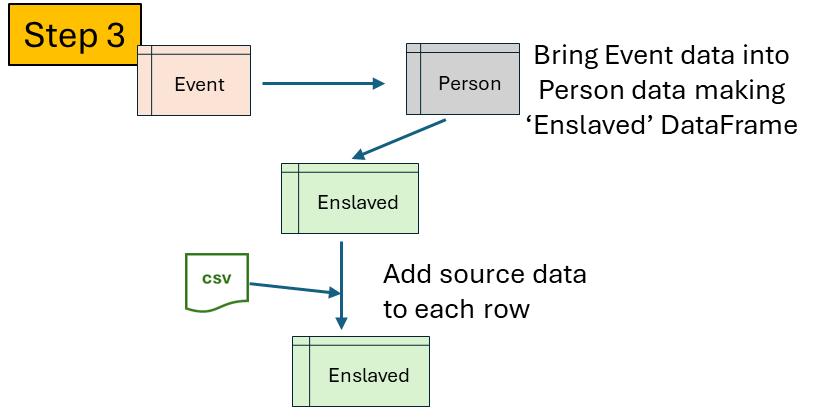

In [45]:
display.Image(filename="ThirdStep.png", width=400, height=400)

In [46]:
enslaved = person.join(events, how='left')
print(enslaved.shape)
enslaved.head()

(2949, 29)


,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Status,Location,Spouse2,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
RN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill,0,EVE-NEC-002,Colleton,43,1770-09-22,2,27,Blankets gave out 1770. 2 Fanny and her childr...,Necessitites,1770
1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill,0,EVE-BIR-013,Union Hill,43,1780-09-25,7,360,The night of the 25 Hannah delivered of a boy ...,Birth,1780
1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill,0,EVE-BIR-017,Union Hill,43,1783-11-05,8,37,Creasy delivered of a girl by Venus,Birth,1783
1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill,0,EVE-BIR-020,Union Hill,43,1785-08-14,8,89,Sam J. Cabell’s Fanny delivered of a boy by ol...,Birth,1785
1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,97,121,0,0,0,0,0,0,Enslaved,UnionHill,0,EVE-BIR-021,Union Hill,43,1785-09-22,8,91,Young Venus delivered of a boy by Old Venus,Birth,1785


## Add Source data

In [47]:
enslaved = enslaved.reset_index()
enslaved = enslaved[['RN','Given Name','Alternate Name','Surname','Sex','Birth date','Death date','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year','Description','Source','Page']]
enslaved['Source'] = enslaved['Source'].astype(float)
enslaved.head()

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Spouse2,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source,Page
0,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,0,97,121,0,0,0,0,0,0,EVE-NEC-002,Necessitites,Colleton,Enslaved,43,1770-09-22,1770,Blankets gave out 1770. 2 Fanny and her childr...,2.0,27
1,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,0,97,121,0,0,0,0,0,0,EVE-BIR-013,Birth,Union Hill,Enslaved,43,1780-09-25,1780,The night of the 25 Hannah delivered of a boy ...,7.0,360
2,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,0,97,121,0,0,0,0,0,0,EVE-BIR-017,Birth,Union Hill,Enslaved,43,1783-11-05,1783,Creasy delivered of a girl by Venus,8.0,37
3,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,0,97,121,0,0,0,0,0,0,EVE-BIR-020,Birth,Union Hill,Enslaved,43,1785-08-14,1785,Sam J. Cabell’s Fanny delivered of a boy by ol...,8.0,89
4,1,Venus,NaN,NaN,F,bef 1745,NaN,0,0,14,0,97,121,0,0,0,0,0,0,EVE-BIR-021,Birth,Union Hill,Enslaved,43,1785-09-22,1785,Young Venus delivered of a boy by Old Venus,8.0,91


In [48]:
#enslaved[enslaved['RN']==308]

In [49]:
#import the Masterfile CSV to work with and a column for "order"
file = "Sources_01192024.csv"
sources = pd.read_csv(file)
sources = trim_all_columns(sources)
print(sources.shape)
sources.head()

(61, 3)


,Source,Source Description,Repository
0,1,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
1,2,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
2,3,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
3,4,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."
4,5,"Cabell, William, Sr. Commonplace books, 1769-1...","Virginia Museum of History and Culture, Richmo..."


In [50]:
sources= sources.sort_values('Source').set_index('Source')
enslaved = enslaved.sort_values('Source').set_index('Source')

In [51]:
enslaved = enslaved.join(sources, how='left').reset_index()
enslaved = enslaved[['RN','Given Name','Alternate Name','Surname','Sex','Birth date','Death date','Father','Mother','Spouse','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year','Description','Source Description','Page','Repository']]
print(enslaved.shape)
enslaved.head()

(2949, 29)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source Description,Page,Repository
0,1171,Sylvia,NaN,NaN,F,bef 1839,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-013,Enslaved,Montezuma,Enslaved,1034,1858,1858,Enslaved by James Bruce McClelland,NaN,,NaN
1,667,Milly,NaN,NaN,F,abt 1830,NaN,665,666,0,0,0,0,0,0,0,0,0,EVE-ENS-013,Enslaved,Montezuma,Enslaved,1034,1858,1858,Enslaved by James Bruce McClelland,NaN,,NaN
2,153,Gabriel,NaN,NaN,M,bef 1785,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-004,Enslaved,Union Hill,Enslaved,43,1795,1795,"Enslaved by William Cabell, Sr.",NaN,,NaN
3,154,Randolph,NaN,NaN,M,bef 1785,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-004,Enslaved,Union Hill,Enslaved,43,1795,1795,"Enslaved by William Cabell, Sr.",NaN,,NaN
4,154,Randolph,NaN,NaN,M,bef 1785,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-052,Enslaved,Midway,Enslaved,269,1800,1800,Enslaved by William H. Cabell,NaN,,NaN


### Change Status from Enslaved to Free for events after 1865 and those emancipated

In [52]:
enslaved['Status'].value_counts()

Status
Enslaved    2949
Name: count, dtype: int64

In [53]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Year']<=1865,'Free')
enslaved['Status'].value_counts()

Status
Enslaved    2928
Free          21
Name: count, dtype: int64

In [54]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Event Type'] !='Emancipation','Free')
enslaved['Status'].value_counts()

Status
Enslaved    2919
Free          30
Name: count, dtype: int64

In [55]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Place'] !='Philadelphia, Pennsylvania','Free')
enslaved['Status'].value_counts()

Status
Enslaved    2905
Free          44
Name: count, dtype: int64

In [56]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Place'] != "Bristol, Bucks, Pennsylvania",'Free')
enslaved['Status'].value_counts()

Status
Enslaved    2904
Free          45
Name: count, dtype: int64

## Step 4

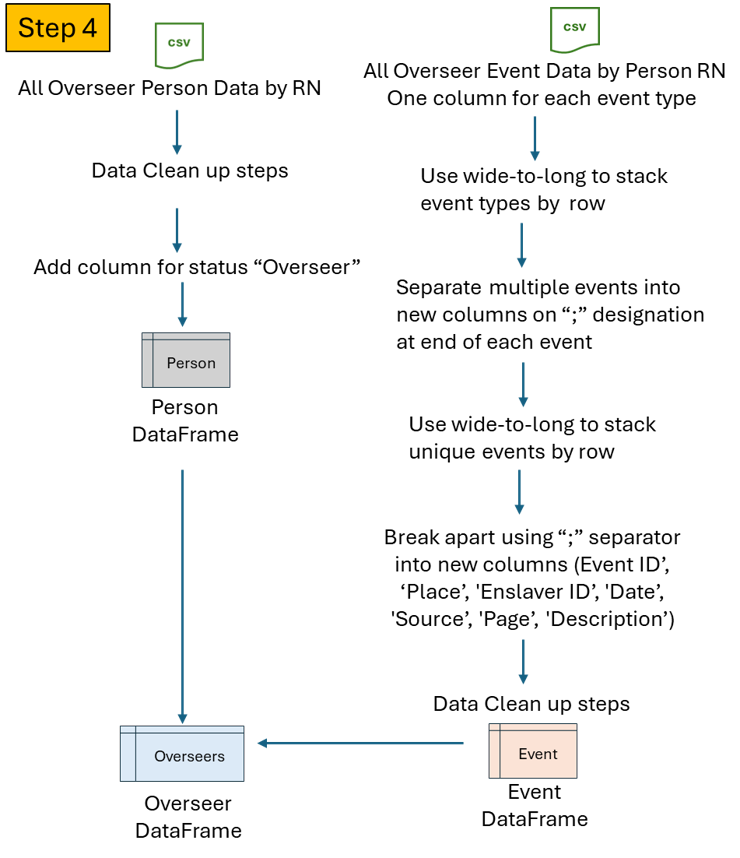

In [57]:
display.Image(filename="FourthStep.png", width=500, height=500)

## Bring in Overseer Person Data

In [58]:
#import the Masterfile CSV to work with and a column for "order"
cols= ['RN','Given Name', 'Alternate Name', 'Surname','Sex','Birth date','Death date','Father','Mother','Spouse']
file = "OVPersonData_01162024.csv"
OVperson = pd.read_csv(file,header=0, names=cols)
OVperson = trim_all_columns(OVperson)

print(OVperson.shape)
OVperson.head()

(47, 10)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse
0,343,Thomas,NaN,Appling,M,Sep 1755,3 Sep 1835,NaN,NaN,Elizabeth Austin-344
1,968,Langston,NaN,Bacon,M,bef 1779,NaN,NaN,NaN,NaN
2,346,Allen,NaN,Blair,M,1754,1834,NaN,NaN,Mary Ann Staples-368
3,969,R.,NaN,Bolton,M,bef 1797,NaN,NaN,NaN,NaN
4,405,John,NaN,Bryant,M,abt 1755,NaN,John Bryant-404,Elizabeth Hamblett-447,NaN


In [59]:
OVperson[OVperson['Given Name']==np.NaN]

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse


In [60]:
OVperson['Spouse'] = OVperson['Spouse'].replace(regex=[r'\D+'], value="")#.astype(str)
OVperson['Father'] = OVperson['Father'].replace(regex=[r'\D+'], value="")#.astype(str)
OVperson['Mother'] = OVperson['Mother'].replace(regex=[r'\D+'], value="")#.astype(str)
OVperson[['Father','Mother','Spouse']] =  OVperson[['Father','Mother','Spouse']] .replace(to_replace=np.NaN, value=0).astype(int)

OVperson['Location'] = 'UnionHill'
OVperson['Status'] = 'Overseer'
OVperson.head(10)

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Location,Status
0,343,Thomas,NaN,Appling,M,Sep 1755,3 Sep 1835,0,0,344,UnionHill,Overseer
1,968,Langston,NaN,Bacon,M,bef 1779,NaN,0,0,0,UnionHill,Overseer
2,346,Allen,NaN,Blair,M,1754,1834,0,0,368,UnionHill,Overseer
3,969,R.,NaN,Bolton,M,bef 1797,NaN,0,0,0,UnionHill,Overseer
4,405,John,NaN,Bryant,M,abt 1755,NaN,404,447,0,UnionHill,Overseer
5,406,Permanus,NaN,Bryant,M,abt 1760,NaN,404,447,0,UnionHill,Overseer
6,412,Benjamin,NaN,Camden,M,abt 1762,NaN,413,0,390,UnionHill,Overseer
7,995,Egbert,NaN,Coffee,M,bef 1832,NaN,0,0,0,UnionHill,Overseer
8,423,Daniel,NaN,Connor,M,abt 1760,NaN,0,0,403,UnionHill,Overseer
9,977,John N.,NaN,Corley,M,abt 1810,NaN,0,0,974,UnionHill,Overseer


In [61]:
OVperson.loc[:, "Child1"] = "0"
OVperson.loc[:, "Child2"] = "0"
OVperson.loc[:, "Child3"] = "0"
OVperson.loc[:, "Child4"] = "0"
OVperson.loc[:, "Child5"] = "0"
OVperson.loc[:, "Child6"] = "0"
OVperson.loc[:, "Child7"] = "0"
OVperson.loc[:, "Child8"] = "0"
OVperson.loc[:, "Spouse2"] = "0"

## Overseer Event Data

### IMPORTANT- Remove all quotation marks (") before uploading file from Roots Magic

In [62]:
#import the Masterfile CSV to work with and a column for "order"
file = "OVEventData_01192024.csv"
OVevents = pd.read_csv(file)
OVevents = trim_all_columns(OVevents)

print(OVevents.shape)
OVevents.head()

(47, 16)


,RN,EVE-ADV,EVE-TAX,EVE-WILL,EVE-CRF,EVE-RET,EVE-OVR,EVE-PUN,EVE-MIL,EVE-ALT,EVE-AGR,EVE-EMN,EVE-CEN,EVE-CEM,EVE-ILL,EVE-MAR
0,343,NaN,NaN,NaN,NaN,NaN,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,968,NaN,NaN,NaN,NaN,NaN,EVE-OVR-049;Union Hill;44;1799-07-23;12;267;Em...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,346,NaN,NaN,NaN,NaN,NaN,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,969,NaN,NaN,NaN,NaN,NaN,EVE-OVR-050;Union Hill;44;1817-08-16;13;422;Ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,405,NaN,NaN,NaN,NaN,NaN,EVE-OVR-010;Colleton;43;1773-11-29;4;;John Bry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
OVevents = pd.wide_to_long(OVevents, stubnames='EVE',i='RN', j='type',sep='-', suffix= '\D+')#text suffixes
OVevents= OVevents.reset_index().drop(columns={'type'}).sort_values('RN').set_index('RN').dropna()
OVevents = trim_all_columns(OVevents)
print(OVevents.shape)
OVevents.head()

(47, 1)


,EVE
RN,
173,EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...
343,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...
346,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...
355,EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...
357,EVE-OVR-011;Colleton;43;1774-07-25;5;7;Agreed ...


### REmove the last ":" colon in each event row - THIS STEP IS CRITICAL

In [64]:
OVevents['EVE'] = OVevents['EVE'].str[:-1]
print(OVevents.shape)
OVevents.head(10)

(47, 1)


,EVE
RN,
173,EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...
343,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...
346,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...
355,EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...
357,EVE-OVR-011;Colleton;43;1774-07-25;5;7;Agreed ...
364,EVE-OVR-023;Union Hill;43;1784-08-18;8;68;Agre...
405,EVE-OVR-010;Colleton;43;1773-11-29;4;;John Bry...
406,EVE-OVR-040;Union Hill;43;1793-07-21;8;266;Agr...
412,EVE-OVR-037;Union Hill;43;1791-08-01;8;223;Agr...


## Sort rows by RN and use new index as unique identifier

In [65]:
OVevents = OVevents.reset_index().reset_index().rename(columns={'index':'Order'}).set_index(['Order','RN'])
OVevents.head()

,,EVE
Order,RN,
0,173,EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...
1,343,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...
2,346,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...
3,355,EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...
4,357,EVE-OVR-011;Colleton;43;1774-07-25;5;7;Agreed ...


In [66]:
OVevents =OVevents['EVE'].str.split(pat=':', expand=True).fillna(np.NaN)
OVevents= OVevents.rename(columns={0:'EVE-A',1:'EVE-B',2:'EVE-C',3:'EVE-D',4:'EVE-D',5:'EVE-E',6:'EVE-F',7:'EVE-G',8:'EVE-H',9:'EVE-I',10:'EVE-J',11:'EVE-K',12:'EVE-L',13:'EVE-M',14:'EVE-N',15:'EVE-O',16:'EVE-P',17:'EVE-Q',18:'EVE-R'})
OVevents = OVevents.reset_index()
OVevents = trim_all_columns(OVevents)
print(OVevents.shape)
OVevents.head()

(47, 6)


,Order,RN,EVE-A,EVE-B,EVE-C,EVE-D
0,0,173,EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...,EVE-OVR-028;Colleton;44;1787-08-12;11;226;Have...,EVE-OVR-044;Colleton;44;1793-10-16;12;255;Have...,NaN
1,1,343,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...,EVE-OVR-027;Colleton;44;1787-08-12;11;226;Have...,EVE-OVR-036;Colleton;44;1791-07-30;11;246;Have...,EVE-OVR-043;Colleton;44;1793-10-14;12;255;Have...
2,2,346,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...,NaN,NaN,NaN
3,3,355,EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...,NaN,NaN,NaN
4,4,357,EVE-OVR-011;Colleton;43;1774-07-25;5;7;Agreed ...,EVE-OVR-012;Colleton;43;1775-09;5;53;Agree wit...,NaN,NaN


In [67]:
OVevents = pd.wide_to_long(OVevents, stubnames='EVE',i=['Order','RN'], j='type',sep='-', suffix= '\D+')#text suffixes
OVevents= OVevents.reset_index().drop(columns={'type','Order'}).drop_duplicates().dropna().sort_values('RN').set_index('RN')
print(OVevents.shape)
OVevents.head(10)

(60, 1)


,EVE
RN,
173,EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...
173,EVE-OVR-028;Colleton;44;1787-08-12;11;226;Have...
173,EVE-OVR-044;Colleton;44;1793-10-16;12;255;Have...
343,EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...
343,EVE-OVR-027;Colleton;44;1787-08-12;11;226;Have...
343,EVE-OVR-036;Colleton;44;1791-07-30;11;246;Have...
343,EVE-OVR-043;Colleton;44;1793-10-14;12;255;Have...
346,EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...
355,EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...


## Now break out to columns for each event using the existing semicolon separator

In [68]:
OVevents =OVevents['EVE'].str.split(pat=';', expand=True)
OVevents = OVevents.rename(columns={0:'Event ID',1:'Place',2:'Enslaver ID',3:'Date',4:'Source',5:'Page',6:'Description'})
OVevents.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description
RN,,,,,,,
173,EVE-OVR-001,Colleton,44,1792-03-28,12,249,"Memo of agreement with Henry Reid, overseer, f..."
173,EVE-OVR-028,Colleton,44,1787-08-12,11,226,"Have agreed with Henry Read, overseer, to over..."
173,EVE-OVR-044,Colleton,44,1793-10-16,12,255,Have employed Henry Reid to be an overseer the...
343,EVE-OVR-002,Colleton,44,1792-03-28,12,249,"Memo of agreement with Thomas Appling, oversee..."
343,EVE-OVR-027,Colleton,44,1787-08-12,11,226,"Have agreed with Tho. Appling, Overseer, to ov..."


### Add column for Event type

In [69]:
OVevents['Event Type'] = OVevents['Event ID'].str[:-4]
OVevents['Event Type'] = OVevents['Event Type'].replace(to_replace='EVE-OVR', value='Overseer')


In [70]:
OVevents['Year'] = OVevents['Date'].str[:4]
OVevents['Year'] = OVevents['Year'].astype(int)
OVevents.head()

,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
RN,,,,,,,,,
173,EVE-OVR-001,Colleton,44,1792-03-28,12,249,"Memo of agreement with Henry Reid, overseer, f...",Overseer,1792
173,EVE-OVR-028,Colleton,44,1787-08-12,11,226,"Have agreed with Henry Read, overseer, to over...",Overseer,1787
173,EVE-OVR-044,Colleton,44,1793-10-16,12,255,Have employed Henry Reid to be an overseer the...,Overseer,1793
343,EVE-OVR-002,Colleton,44,1792-03-28,12,249,"Memo of agreement with Thomas Appling, oversee...",Overseer,1792
343,EVE-OVR-027,Colleton,44,1787-08-12,11,226,"Have agreed with Tho. Appling, Overseer, to ov...",Overseer,1787


In [71]:
OVevents.dtypes

Event ID       object
Place          object
Enslaver ID    object
Date           object
Source         object
Page           object
Description    object
Event Type     object
Year            int32
dtype: object

## Now link back to person data

In [72]:
OVperson = OVperson.sort_values('RN').set_index('RN')
overseers = OVperson.join(OVevents, how='left').reset_index()
print(overseers.shape)
overseers.head()

(60, 30)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Location,Status,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Spouse2,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year
0,173,Henry,NaN,Reid,M,abt 1762,NaN,0,0,0,UnionHill,Overseer,0,0,0,0,0,0,0,0,0,EVE-OVR-001,Colleton,44,1792-03-28,12,249,"Memo of agreement with Henry Reid, overseer, f...",Overseer,1792
1,173,Henry,NaN,Reid,M,abt 1762,NaN,0,0,0,UnionHill,Overseer,0,0,0,0,0,0,0,0,0,EVE-OVR-028,Colleton,44,1787-08-12,11,226,"Have agreed with Henry Read, overseer, to over...",Overseer,1787
2,173,Henry,NaN,Reid,M,abt 1762,NaN,0,0,0,UnionHill,Overseer,0,0,0,0,0,0,0,0,0,EVE-OVR-044,Colleton,44,1793-10-16,12,255,Have employed Henry Reid to be an overseer the...,Overseer,1793
3,343,Thomas,NaN,Appling,M,Sep 1755,3 Sep 1835,0,0,344,UnionHill,Overseer,0,0,0,0,0,0,0,0,0,EVE-OVR-002,Colleton,44,1792-03-28,12,249,"Memo of agreement with Thomas Appling, oversee...",Overseer,1792
4,343,Thomas,NaN,Appling,M,Sep 1755,3 Sep 1835,0,0,344,UnionHill,Overseer,0,0,0,0,0,0,0,0,0,EVE-OVR-027,Colleton,44,1787-08-12,11,226,"Have agreed with Tho. Appling, Overseer, to ov...",Overseer,1787


In [73]:
overseers['RN'] = overseers['RN'].astype(str)
overseers.dtypes

RN                 object
Given Name         object
Alternate Name    float64
Surname            object
Sex                object
Birth date         object
Death date         object
Father              int32
Mother              int32
Spouse              int32
Location           object
Status             object
Child1             object
Child2             object
Child3             object
Child4             object
Child5             object
Child6             object
Child7             object
Child8             object
Spouse2            object
Event ID           object
Place              object
Enslaver ID        object
Date               object
Source             object
Page               object
Description        object
Event Type         object
Year                int32
dtype: object

In [74]:
overseers['Person'] = 'PERS-CAB-'+overseers['RN']+'-UH'


## Create hold dataframe for overseers by enslaver for later

In [75]:
hold = overseers[['Person','Enslaver ID','Year']]
print(hold.shape)
hold.head()

(60, 3)


,Person,Enslaver ID,Year
0,PERS-CAB-173-UH,44,1792
1,PERS-CAB-173-UH,44,1787
2,PERS-CAB-173-UH,44,1793
3,PERS-CAB-343-UH,44,1792
4,PERS-CAB-343-UH,44,1787


## Step 5

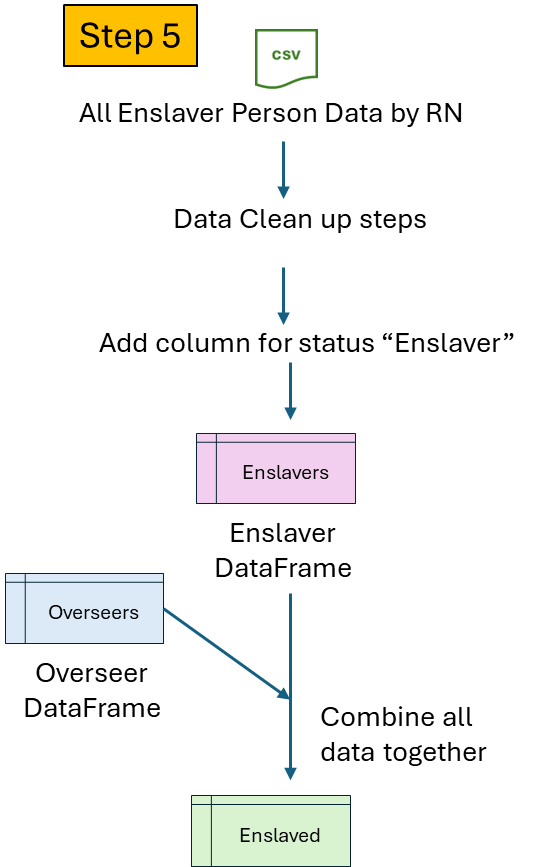

In [76]:
display.Image(filename="Fifth Step.png", width=300, height=300)

## Bring in Enslaver Person Data

In [77]:
#import the Masterfile CSV to work with and a column for "order"
cols= ['RN','Given Name', 'Alternate Name', 'Surname','Sex','Birth date','Death date','Father','Mother','Spouse','Spouse2']
file = "ENSLAVERSPersonData_01162024.csv"
ENperson = pd.read_csv(file, header=0, names=cols)
ENperson = trim_all_columns(ENperson)

print(ENperson.shape)
ENperson.head()

(90, 11)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Spouse2
0,118,James W.,NaN,Alexander,M,abt 1750,29 Jun 1814,NaN,NaN,1042,NaN
1,1178,Martin D.,NaN,Alsom,M,bef 1838,NaN,NaN,NaN,NaN,NaN
2,860,Caroline,NaN,Anthony,F,21 May 1822,3 May 1908,NaN,NaN,45,NaN
3,678,John,NaN,Anthony,M,NaN,NaN,NaN,NaN,NaN,NaN
4,911,Anne Blaws,NaN,Barraud,F,1784,1816,NaN,NaN,910,NaN


In [78]:
ENperson[ENperson['Given Name']==np.NaN]

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Spouse2


In [79]:
ENperson['Spouse'] = ENperson['Spouse'].replace(regex=[r'\D+'], value=" ")#.astype(str)
ENperson['Father'] = ENperson['Father'].replace(regex=[r'\D+'], value=" ")#.astype(str)
ENperson['Mother'] = ENperson['Mother'].replace(regex=[r'\D+'], value=" ")#.astype(str)
ENperson['Spouse2'] = ENperson['Spouse2'].replace(regex=[r'\D+'], value=" ")#.astype(str)
ENperson[['Father','Mother','Spouse','Spouse2']] =  ENperson[['Father','Mother','Spouse','Spouse2']] .replace(to_replace=np.NaN, value=0).astype(int)

ENperson['Location'] = 'UnionHill'
ENperson['Status'] = 'Enslaver'
ENperson.head(10)

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Spouse2,Location,Status
0,118,James W.,NaN,Alexander,M,abt 1750,29 Jun 1814,0,0,1042,0,UnionHill,Enslaver
1,1178,Martin D.,NaN,Alsom,M,bef 1838,NaN,0,0,0,0,UnionHill,Enslaver
2,860,Caroline,NaN,Anthony,F,21 May 1822,3 May 1908,0,0,45,0,UnionHill,Enslaver
3,678,John,NaN,Anthony,M,NaN,NaN,0,0,0,0,UnionHill,Enslaver
4,911,Anne Blaws,NaN,Barraud,F,1784,1816,0,0,910,0,UnionHill,Enslaver
5,1136,F. C.,NaN,Brady,M,bef 1820,NaN,0,0,0,0,UnionHill,Enslaver
6,915,Arthur Lee,NaN,Brent,M,1821,1871,0,0,914,0,UnionHill,Enslaver
7,106,Adam,NaN,Brown,M,abt 1760,1785,398,0,0,0,UnionHill,Enslaver
8,216,Robert Lawrence,NaN,Brown,M,9 Mar 1820,1880,0,0,215,859,UnionHill,Enslaver
9,757,James,NaN,Bruce,M,1763,12 May 1837,0,0,281,0,UnionHill,Enslaver


In [80]:
ENperson.loc[:, "Child1"] = "0"
ENperson.loc[:, "Child2"] = "0"
ENperson.loc[:, "Child3"] = "0"
ENperson.loc[:, "Child4"] = "0"
ENperson.loc[:, "Child5"] = "0"
ENperson.loc[:, "Child6"] = "0"
ENperson.loc[:, "Child7"] = "0"
ENperson.loc[:, "Child8"] = "0"
ENperson.head(10)

,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Spouse2,Location,Status,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8
0,118,James W.,NaN,Alexander,M,abt 1750,29 Jun 1814,0,0,1042,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
1,1178,Martin D.,NaN,Alsom,M,bef 1838,NaN,0,0,0,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
2,860,Caroline,NaN,Anthony,F,21 May 1822,3 May 1908,0,0,45,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
3,678,John,NaN,Anthony,M,NaN,NaN,0,0,0,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
4,911,Anne Blaws,NaN,Barraud,F,1784,1816,0,0,910,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
5,1136,F. C.,NaN,Brady,M,bef 1820,NaN,0,0,0,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
6,915,Arthur Lee,NaN,Brent,M,1821,1871,0,0,914,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
7,106,Adam,NaN,Brown,M,abt 1760,1785,398,0,0,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0
8,216,Robert Lawrence,NaN,Brown,M,9 Mar 1820,1880,0,0,215,859,UnionHill,Enslaver,0,0,0,0,0,0,0,0
9,757,James,NaN,Bruce,M,1763,12 May 1837,0,0,281,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0


## Join all person and event data together

In [81]:
df = pd.concat([ENperson,overseers])
print(df.shape)
df.head()
      

(150, 31)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Spouse2,Location,Status,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Event ID,Place,Enslaver ID,Date,Source,Page,Description,Event Type,Year,Person
0,118,James W.,NaN,Alexander,M,abt 1750,29 Jun 1814,0,0,1042,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1178,Martin D.,NaN,Alsom,M,bef 1838,NaN,0,0,0,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,860,Caroline,NaN,Anthony,F,21 May 1822,3 May 1908,0,0,45,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,678,John,NaN,Anthony,M,NaN,NaN,0,0,0,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,911,Anne Blaws,NaN,Barraud,F,1784,1816,0,0,910,0,UnionHill,Enslaver,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 6

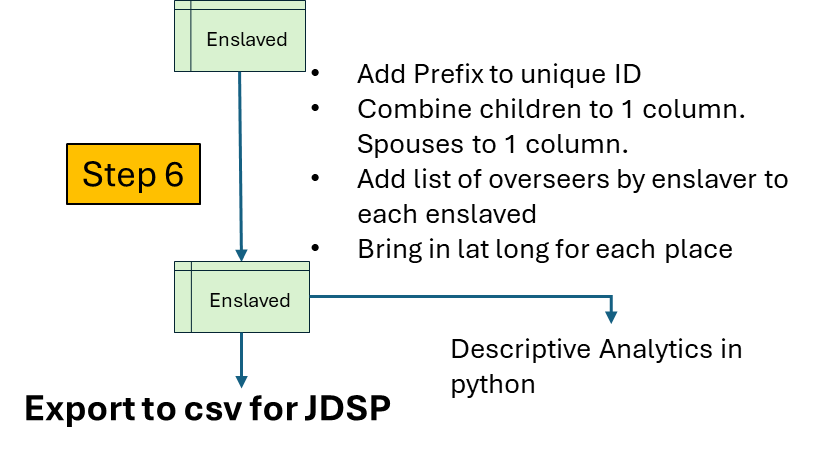

In [82]:
display.Image(filename="SixthStep.png", width=500, height=500)

## Join back to Enslaved DataFrame

In [83]:
enslaved = pd.concat([enslaved,df])
#reorganize columns
enslaved[['RN','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']] = enslaved[['RN','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']].fillna('0').astype(str)
enslaved.head()
print(enslaved.shape)
enslaved.head()

(3099, 33)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source Description,Page,Repository,Spouse2,Location,Source,Person
0,1171,Sylvia,NaN,NaN,F,bef 1839,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-013,Enslaved,Montezuma,Enslaved,1034,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,0,NaN,NaN,NaN
1,667,Milly,NaN,NaN,F,abt 1830,NaN,665,666,0,0,0,0,0,0,0,0,0,EVE-ENS-013,Enslaved,Montezuma,Enslaved,1034,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,0,NaN,NaN,NaN
2,153,Gabriel,NaN,NaN,M,bef 1785,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-004,Enslaved,Union Hill,Enslaved,43,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,0,NaN,NaN,NaN
3,154,Randolph,NaN,NaN,M,bef 1785,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-004,Enslaved,Union Hill,Enslaved,43,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,0,NaN,NaN,NaN
4,154,Randolph,NaN,NaN,M,bef 1785,NaN,0,0,0,0,0,0,0,0,0,0,0,EVE-ENS-052,Enslaved,Midway,Enslaved,269,1800,1800.0,Enslaved by William H. Cabell,NaN,,NaN,0,NaN,NaN,NaN


## Fix Individual to have 'PERS-CAB-' in front of the RN and '-UH' on the back of the RN

### For each plantation set, the last element will change, but the person can be matched across plantations with the prefix and number part

In [84]:
enslaved['Person'] = 'PERS-CAB-'+enslaved['RN']+'-UH'
enslaved['Father'] = 'PERS-CAB-'+enslaved['Father']+'-UH'
enslaved['Mother'] = 'PERS-CAB-'+enslaved['Mother']+'-UH'
enslaved['Spouse'] = 'PERS-CAB-'+enslaved['Spouse']+'-UH'
enslaved['Spouse2'] = 'PERS-CAB-'+enslaved['Spouse2']+'-UH'
enslaved['Enslaver ID'] = 'PERS-CAB-'+enslaved['Enslaver ID']+'-UH'
print(enslaved.shape)
enslaved.head()

(3099, 33)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source Description,Page,Repository,Spouse2,Location,Source,Person
0,1171,Sylvia,NaN,NaN,F,bef 1839,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,0,0,0,0,0,0,0,0,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-1171-UH
1,667,Milly,NaN,NaN,F,abt 1830,NaN,PERS-CAB-665-UH,PERS-CAB-666-UH,PERS-CAB-0-UH,0,0,0,0,0,0,0,0,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-667-UH
2,153,Gabriel,NaN,NaN,M,bef 1785,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,0,0,0,0,0,0,0,0,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-153-UH
3,154,Randolph,NaN,NaN,M,bef 1785,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,0,0,0,0,0,0,0,0,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-154-UH
4,154,Randolph,NaN,NaN,M,bef 1785,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,0,0,0,0,0,0,0,0,EVE-ENS-052,Enslaved,Midway,Enslaved,PERS-CAB-269-UH,1800,1800.0,Enslaved by William H. Cabell,NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-154-UH


In [85]:
enslaved[['Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']] = enslaved[['Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']].astype(str)
enslaved['Child1'] = 'PERS-CAB-'+enslaved['Child1']+'-UH'
enslaved['Child2'] = 'PERS-CAB-'+enslaved['Child2']+'-UH'
enslaved['Child3'] = 'PERS-CAB-'+enslaved['Child3']+'-UH'
enslaved['Child4'] = 'PERS-CAB-'+enslaved['Child4']+'-UH'
enslaved['Child5'] = 'PERS-CAB-'+enslaved['Child5']+'-UH'
enslaved['Child6'] = 'PERS-CAB-'+enslaved['Child6']+'-UH'
enslaved['Child7'] = 'PERS-CAB-'+enslaved['Child7']+'-UH'
enslaved['Child8'] = 'PERS-CAB-'+enslaved['Child8']+'-UH'
print(enslaved.shape)
enslaved.head()

(3099, 33)


,RN,Given Name,Alternate Name,Surname,Sex,Birth date,Death date,Father,Mother,Spouse,Child1,Child2,Child3,Child4,Child5,Child6,Child7,Child8,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source Description,Page,Repository,Spouse2,Location,Source,Person
0,1171,Sylvia,NaN,NaN,F,bef 1839,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-1171-UH
1,667,Milly,NaN,NaN,F,abt 1830,NaN,PERS-CAB-665-UH,PERS-CAB-666-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-667-UH
2,153,Gabriel,NaN,NaN,M,bef 1785,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-153-UH
3,154,Randolph,NaN,NaN,M,bef 1785,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-154-UH
4,154,Randolph,NaN,NaN,M,bef 1785,NaN,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,PERS-CAB-0-UH,EVE-ENS-052,Enslaved,Midway,Enslaved,PERS-CAB-269-UH,1800,1800.0,Enslaved by William H. Cabell,NaN,,NaN,PERS-CAB-0-UH,NaN,NaN,PERS-CAB-154-UH


In [86]:
#Now clear all 'PERS-0'
enslaved = enslaved.replace(to_replace='PERS-CAB-0-UH', value='')
enslaved = enslaved.replace(to_replace='PERS-CAB--UH', value='')
#enslaved['Enslaver ID'].value_counts()

### Combine Children into one column

In [87]:
enslaved['Children'] = enslaved[['Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
# Fix order of the columns
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouse','Spouse2','Children','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year','Description','Source Description','Page','Repository']]
enslaved.head()


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouse,Spouse2,Children,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source Description,Page,Repository
0,PERS-CAB-1171-UH,Sylvia,NaN,NaN,F,1171,bef 1839,NaN,,,,,,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN
1,PERS-CAB-667-UH,Milly,NaN,NaN,F,667,abt 1830,NaN,PERS-CAB-665-UH,PERS-CAB-666-UH,,,,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN
2,PERS-CAB-153-UH,Gabriel,NaN,NaN,M,153,bef 1785,NaN,,,,,,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN
3,PERS-CAB-154-UH,Randolph,NaN,NaN,M,154,bef 1785,NaN,,,,,,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN
4,PERS-CAB-154-UH,Randolph,NaN,NaN,M,154,bef 1785,NaN,,,,,,EVE-ENS-052,Enslaved,Midway,Enslaved,PERS-CAB-269-UH,1800,1800.0,Enslaved by William H. Cabell,NaN,,NaN


### Combine Spouse into one column

In [88]:
enslaved['Spouses'] = enslaved[['Spouse','Spouse2']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
enslaved = enslaved.drop(columns={'Spouse','Spouse2'})
print(enslaved.shape)
enslaved.head(5)

(3099, 23)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Children,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year,Description,Source Description,Page,Repository,Spouses
0,PERS-CAB-1171-UH,Sylvia,NaN,NaN,F,1171,bef 1839,NaN,,,,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,
1,PERS-CAB-667-UH,Milly,NaN,NaN,F,667,abt 1830,NaN,PERS-CAB-665-UH,PERS-CAB-666-UH,,EVE-ENS-013,Enslaved,Montezuma,Enslaved,PERS-CAB-1034-UH,1858,1858.0,Enslaved by James Bruce McClelland,NaN,,NaN,
2,PERS-CAB-153-UH,Gabriel,NaN,NaN,M,153,bef 1785,NaN,,,,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,
3,PERS-CAB-154-UH,Randolph,NaN,NaN,M,154,bef 1785,NaN,,,,EVE-ENS-004,Enslaved,Union Hill,Enslaved,PERS-CAB-43-UH,1795,1795.0,"Enslaved by William Cabell, Sr.",NaN,,NaN,
4,PERS-CAB-154-UH,Randolph,NaN,NaN,M,154,bef 1785,NaN,,,,EVE-ENS-052,Enslaved,Midway,Enslaved,PERS-CAB-269-UH,1800,1800.0,Enslaved by William H. Cabell,NaN,,NaN,


## Add List of Overseers by enslaver to RN's 

In [89]:
hold.head()

,Person,Enslaver ID,Year
0,PERS-CAB-173-UH,44,1792
1,PERS-CAB-173-UH,44,1787
2,PERS-CAB-173-UH,44,1793
3,PERS-CAB-343-UH,44,1792
4,PERS-CAB-343-UH,44,1787


In [90]:
hold = hold.sort_values('Year').rename(columns={'Person':'Overseer'}).drop(columns={'Year'}).drop_duplicates().sort_values(['Enslaver ID','Overseer'])
hold['count'] = hold.groupby('Enslaver ID').cumcount()
#hold[['Enslaver ID','Overseer']] = hold[['Enslaver ID','Overseer']].astype(int)
hold = hold.sort_values(['Enslaver ID','count'])
print(hold.shape)
hold.head(15)

(50, 3)


,Overseer,Enslaver ID,count
26,PERS-CAB-531-UH,272,0
7,PERS-CAB-346-UH,43,0
8,PERS-CAB-355-UH,43,1
9,PERS-CAB-357-UH,43,2
11,PERS-CAB-364-UH,43,3
14,PERS-CAB-405-UH,43,4
15,PERS-CAB-406-UH,43,5
16,PERS-CAB-412-UH,43,6
17,PERS-CAB-423-UH,43,7
18,PERS-CAB-425-UH,43,8


In [91]:
hold = hold.reset_index()
hold = hold.rename(columns={'index':'order'})
print(hold.shape)
hold.head()

(50, 4)


,order,Overseer,Enslaver ID,count
0,26,PERS-CAB-531-UH,272,0
1,7,PERS-CAB-346-UH,43,0
2,8,PERS-CAB-355-UH,43,1
3,9,PERS-CAB-357-UH,43,2
4,11,PERS-CAB-364-UH,43,3


In [92]:
hold = hold.pivot(index=['Enslaver ID','order'], columns='count', values='Overseer')
print(hold.shape)
hold.head(20)

(50, 28)


count                           0                1                2   \
Enslaver ID order                                                      
272         26     PERS-CAB-531-UH              NaN              NaN   
43          7      PERS-CAB-346-UH              NaN              NaN   
            8                  NaN  PERS-CAB-355-UH              NaN   
            9                  NaN              NaN  PERS-CAB-357-UH   
            11                 NaN              NaN              NaN   
            14                 NaN              NaN              NaN   
            15                 NaN              NaN              NaN   
            16                 NaN              NaN              NaN   
            17                 NaN              NaN              NaN   
            18                 NaN              NaN              NaN   
            19                 NaN              NaN              NaN   
            20                 NaN              NaN              NaN   
            21                 NaN              NaN              NaN   
            22                 NaN              NaN              NaN   
            23                 NaN              NaN              NaN   
            24                 NaN              NaN              NaN   
            25                 NaN              NaN              NaN   
            27                 NaN              NaN              NaN   
            29                 NaN              NaN              NaN   
            30                 NaN              NaN              NaN   

count                           3                4                5   \
Enslaver ID order                                                      
272         26                 NaN              NaN              NaN   
43          7                  NaN              NaN              NaN   
            8                  NaN              NaN              NaN   
            9                  NaN              NaN              NaN   
            11     PERS-CAB-364-UH              NaN              NaN   
            14                 NaN  PERS-CAB-405-UH              NaN   
            15                 NaN              NaN  PERS-CAB-406-UH   
            16                 NaN              NaN              NaN   
            17                 NaN              NaN              NaN   
            18                 NaN              NaN              NaN   
            19                 NaN              NaN              NaN   
            20                 NaN              NaN              NaN   
            21                 NaN              NaN              NaN   
            22                 NaN              NaN              NaN   
            23                 NaN              NaN              NaN   
            24                 NaN              NaN              NaN   
            25                 NaN              NaN              NaN   
            27                 NaN              NaN              NaN   
            29                 NaN              NaN              NaN   
            30                 NaN              NaN              NaN   

count                           6                7                8   \
Enslaver ID order                                                      
272         26                 NaN              NaN              NaN   
43          7                  NaN              NaN              NaN   
            8                  NaN              NaN              NaN   
            9                  NaN              NaN              NaN   
            11                 NaN              NaN              NaN   
            14                 NaN              NaN              NaN   
            15                 NaN              NaN              NaN   
            16     PERS-CAB-412-UH              NaN              NaN   
            17                 NaN  PERS-CAB-423-UH              NaN   
            18                 NaN    

### Shift all overseers by enslaver to one line for the enslaver

In [93]:
hold[1] = hold[1].shift(periods=-1)
hold[2] = hold[2].shift(periods=-2)
hold[3] = hold[3].shift(periods=-3)
hold[4] = hold[4].shift(periods=-4)
hold[5] = hold[5].shift(periods=-5)
hold[6] = hold[6].shift(periods=-6)
hold[7] = hold[7].shift(periods=-7)
hold[8] = hold[8].shift(periods=-8)
hold[9] = hold[9].shift(periods=-9)
hold[10] = hold[10].shift(periods=-10)
hold[11] = hold[11].shift(periods=-11)
hold[12] = hold[12].shift(periods=-12)
hold[13] = hold[13].shift(periods=-13)
hold[14] = hold[14].shift(periods=-14)
hold[15] = hold[15].shift(periods=-15)
hold[16] = hold[16].shift(periods=-16)
hold[17] = hold[17].shift(periods=-17)
hold[18] = hold[18].shift(periods=-18)
hold[19] = hold[19].shift(periods=-19)
hold[20] = hold[20].shift(periods=-20)
hold[21] = hold[21].shift(periods=-21)
hold[22] = hold[22].shift(periods=-22)
hold[23] = hold[23].shift(periods=-23)
hold[24] = hold[24].shift(periods=-24)
hold[25] = hold[25].shift(periods=-25)
hold[26] = hold[26].shift(periods=-26)
hold[27] = hold[27].shift(periods=-27)

hold = hold.reset_index(level=1,drop=True).reset_index().dropna(subset=[0])
hold


count,Enslaver ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,272,PERS-CAB-531-UH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,43,PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-UH,PERS-CAB-364-UH,PERS-CAB-405-UH,PERS-CAB-406-UH,PERS-CAB-412-UH,PERS-CAB-423-UH,PERS-CAB-425-UH,PERS-CAB-430-UH,PERS-CAB-446-UH,PERS-CAB-459-UH,PERS-CAB-462-UH,PERS-CAB-477-UH,PERS-CAB-507-UH,PERS-CAB-513-UH,PERS-CAB-532-UH,PERS-CAB-534-UH,PERS-CAB-539-UH,PERS-CAB-549-UH,PERS-CAB-556-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-562-UH,PERS-CAB-571-UH,PERS-CAB-587-UH,PERS-CAB-597-UH,PERS-CAB-965-UH
29,44,PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-575-UH,PERS-CAB-967-UH,PERS-CAB-968-UH,PERS-CAB-969-UH,PERS-CAB-970-UH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None
43,45,PERS-CAB-1000-UH,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
44,857,PERS-CAB-977-UH,PERS-CAB-981-UH,PERS-CAB-987-UH,PERS-CAB-989-UH,PERS-CAB-998-UH,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
49,858,PERS-CAB-998-UH,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [94]:
hold = hold.fillna('0')
hold

count,Enslaver ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,272,PERS-CAB-531-UH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-UH,PERS-CAB-364-UH,PERS-CAB-405-UH,PERS-CAB-406-UH,PERS-CAB-412-UH,PERS-CAB-423-UH,PERS-CAB-425-UH,PERS-CAB-430-UH,PERS-CAB-446-UH,PERS-CAB-459-UH,PERS-CAB-462-UH,PERS-CAB-477-UH,PERS-CAB-507-UH,PERS-CAB-513-UH,PERS-CAB-532-UH,PERS-CAB-534-UH,PERS-CAB-539-UH,PERS-CAB-549-UH,PERS-CAB-556-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-562-UH,PERS-CAB-571-UH,PERS-CAB-587-UH,PERS-CAB-597-UH,PERS-CAB-965-UH
29,44,PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-575-UH,PERS-CAB-967-UH,PERS-CAB-968-UH,PERS-CAB-969-UH,PERS-CAB-970-UH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43,45,PERS-CAB-1000-UH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44,857,PERS-CAB-977-UH,PERS-CAB-981-UH,PERS-CAB-987-UH,PERS-CAB-989-UH,PERS-CAB-998-UH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49,858,PERS-CAB-998-UH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
hold = hold.astype(str)
hold['Enslaver ID'] = 'PERS-CAB-'+ hold['Enslaver ID']+'-UH'
#Now clear all 'PERS-0'
hold = hold.replace(to_replace='0', value='')

hold

count,Enslaver ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,PERS-CAB-272-UH,PERS-CAB-531-UH,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,PERS-CAB-43-UH,PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-UH,PERS-CAB-364-UH,PERS-CAB-405-UH,PERS-CAB-406-UH,PERS-CAB-412-UH,PERS-CAB-423-UH,PERS-CAB-425-UH,PERS-CAB-430-UH,PERS-CAB-446-UH,PERS-CAB-459-UH,PERS-CAB-462-UH,PERS-CAB-477-UH,PERS-CAB-507-UH,PERS-CAB-513-UH,PERS-CAB-532-UH,PERS-CAB-534-UH,PERS-CAB-539-UH,PERS-CAB-549-UH,PERS-CAB-556-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-562-UH,PERS-CAB-571-UH,PERS-CAB-587-UH,PERS-CAB-597-UH,PERS-CAB-965-UH
29,PERS-CAB-44-UH,PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-575-UH,PERS-CAB-967-UH,PERS-CAB-968-UH,PERS-CAB-969-UH,PERS-CAB-970-UH,,,,,,,,,,,,,,,,,,,
43,PERS-CAB-45-UH,PERS-CAB-1000-UH,,,,,,,,,,,,,,,,,,,,,,,,,,,
44,PERS-CAB-857-UH,PERS-CAB-977-UH,PERS-CAB-981-UH,PERS-CAB-987-UH,PERS-CAB-989-UH,PERS-CAB-998-UH,,,,,,,,,,,,,,,,,,,,,,,
49,PERS-CAB-858-UH,PERS-CAB-998-UH,,,,,,,,,,,,,,,,,,,,,,,,,,,


#### Combine overseers into one column

In [96]:
hold['Overseers'] = hold[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
hold = hold.drop(columns={0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27})
hold

count,Enslaver ID,Overseers
0,PERS-CAB-272-UH,PERS-CAB-531-UH
1,PERS-CAB-43-UH,PERS-CAB-346-UH PERS-CAB-355-UH PERS-CAB-357-U...
29,PERS-CAB-44-UH,PERS-CAB-173-UH PERS-CAB-343-UH PERS-CAB-560-U...
43,PERS-CAB-45-UH,PERS-CAB-1000-UH
44,PERS-CAB-857-UH,PERS-CAB-977-UH PERS-CAB-981-UH PERS-CAB-987-U...
49,PERS-CAB-858-UH,PERS-CAB-998-UH


In [97]:
hold = hold.sort_values('Enslaver ID').set_index('Enslaver ID').unstack().to_frame().reset_index().rename(columns={0:'Overseers'}).drop(columns={'count'})
hold

,Enslaver ID,Overseers
0,PERS-CAB-272-UH,PERS-CAB-531-UH
1,PERS-CAB-43-UH,PERS-CAB-346-UH PERS-CAB-355-UH PERS-CAB-357-U...
2,PERS-CAB-44-UH,PERS-CAB-173-UH PERS-CAB-343-UH PERS-CAB-560-U...
3,PERS-CAB-45-UH,PERS-CAB-1000-UH
4,PERS-CAB-857-UH,PERS-CAB-977-UH PERS-CAB-981-UH PERS-CAB-987-U...
5,PERS-CAB-858-UH,PERS-CAB-998-UH


In [98]:
hold = hold.sort_values('Enslaver ID').set_index('Enslaver ID')

#### Rejoin overseers by enslaverID to enslaved dataframe

In [99]:
enslaved['Enslaver ID'].value_counts().head(10)

Enslaver ID
PERS-CAB-45-UH      743
PERS-CAB-44-UH      555
PERS-CAB-43-UH      550
PERS-CAB-857-UH     234
PERS-CAB-272-UH     155
PERS-CAB-1088-UH    147
PERS-CAB-283-UH      96
PERS-CAB-1065-UH     89
PERS-CAB-858-UH      63
PERS-CAB-271-UH      53
Name: count, dtype: int64

In [100]:
enslaved = enslaved.sort_values('Enslaver ID').set_index('Enslaver ID')

In [101]:
enslaved.head()

,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Children,Event ID,Event Type,Place,Status,Date,Year,Description,Source Description,Page,Repository,Spouses
Enslaver ID,,,,,,,,,,,,,,,,,,,,,,
,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-EMN-001,Emancipation,Soldier's Joy,Free,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...","Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va.",
,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",Free,1850-08-15,1850.0,"Dwelling 633, Family 839, Banks Family. Rebecc...","Pennsylvania, Moyamensing Ward 3, Philadelphia...",381B,Ancestry.com ( http://www.ancestry.com : 2009),
,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-EMN-001,Emancipation,Soldier's Joy,Free,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...","Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va.",
,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-EMN-001,Emancipation,Soldier's Joy,Free,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...","Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va.",
,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,,,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...,EVE-RES-032,Residence,"Washington, DC",Free,1866-11-24,1866.0,"Opened Bank account in Washington, D.C Account...",Records of the Field Offices for the State of ...,,Ancestry.com (http://ancestry.com : 19 Jan 2024),PERS-CAB-308-UH


In [102]:
enslaved = enslaved.join(hold).reset_index()
print(enslaved.shape)
enslaved.head(5)

(3099, 24)


,Enslaver ID,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Children,Event ID,Event Type,Place,Status,Date,Year,Description,Source Description,Page,Repository,Spouses,Overseers
0,,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-EMN-001,Emancipation,Soldier's Joy,Free,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...","Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va.",,NaN
1,,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",Free,1850-08-15,1850.0,"Dwelling 633, Family 839, Banks Family. Rebecc...","Pennsylvania, Moyamensing Ward 3, Philadelphia...",381B,Ancestry.com ( http://www.ancestry.com : 2009),,NaN
2,,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-EMN-001,Emancipation,Soldier's Joy,Free,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...","Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va.",,NaN
3,,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,EVE-EMN-001,Emancipation,Soldier's Joy,Free,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...","Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va.",,NaN
4,,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,,,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...,EVE-RES-032,Residence,"Washington, DC",Free,1866-11-24,1866.0,"Opened Bank account in Washington, D.C Account...",Records of the Field Offices for the State of ...,,Ancestry.com (http://ancestry.com : 19 Jan 2024),PERS-CAB-308-UH,NaN


In [103]:
enslaved['Place'].value_counts()

Place
Union Hill                          1467
Colleton                             452
Soldier's Joy                        396
Montezuma                            218
Norwood                              214
Benvenue                              51
Unknown                               41
Amherst County, Virginia              39
Lovingston, Nelson, Virginia          18
Philadelphia, Pennsylvania            14
Winton, Amherst County, Virginia      13
Mountain View, Clifford, Amherst      12
Glenmore                              11
Richmond, Virginia                     6
Buckingham County, Virginia            5
Liberty Hall                           5
Oak Ridge                              4
Midway                                 4
Halifax County, Virginia               4
Williamsburg, Virginia                 4
Rose Hill                              3
Bremo, Fluvanna, Virginia              3
Belmont                                3
Fluvanna County, Virginia              2
Buckingham

### Bring in Lat Long of homes and places

In [104]:
#import the Masterfile CSV to work with and a column for "order"
file = "geo_places.csv"
homes = pd.read_csv(file).rename(columns={'Home':'Place'})
homes = trim_all_columns(homes)
print(homes.shape)
homes.head()

(89, 3)


,Place,lat,long
0,Above Centre Hill,37.564051,-78.839138
1,Alta Vista (Rectory),37.644952,-78.808547
2,Banister Lodge,36.769458,-78.917682
3,Belmont,37.675520,-78.833410
4,Below Centre Hill,37.540904,-78.838915


In [105]:
homes = homes[['Place','lat','long']]
homes= homes.sort_values('Place')
homes.head()

,Place,lat,long
0,Above Centre Hill,37.564051,-78.839138
1,Alta Vista (Rectory),37.644952,-78.808547
74,"Amherst County, Virginia",37.581712,-79.048750
73,"Amherst, Virginia",37.581712,-79.048750
80,"Augusta County, Virginia, United States",38.129496,-79.120816


In [106]:
#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=None, indicator=False, validate=None)
enslaved = enslaved.merge(homes, how='left',left_on='Place', right_on='Place')
# Fix order of the columns
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','lat','long','Status','Enslaver ID','Date','Year','Description','Overseers','Source Description','Page','Repository']]

print(enslaved.shape)
enslaved.head()

(3099, 26)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Year,Description,Overseers,Source Description,Page,Repository
0,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va."
1,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",39.925937,-75.169597,Free,,1850-08-15,1850.0,"Dwelling 633, Family 839, Banks Family. Rebecc...",NaN,"Pennsylvania, Moyamensing Ward 3, Philadelphia...",381B,Ancestry.com ( http://www.ancestry.com : 2009)
2,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va."
3,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,,,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",,"Nelson County Circuit Court, Lovingston, Va."
4,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,,,PERS-CAB-308-UH,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...,EVE-RES-032,Residence,"Washington, DC",38.906445,-77.036548,Free,,1866-11-24,1866.0,"Opened Bank account in Washington, D.C Account...",NaN,Records of the Field Offices for the State of ...,,Ancestry.com (http://ancestry.com : 19 Jan 2024)


### Replace blank cells with np.NaN

In [107]:
enslaved = enslaved.replace(to_replace='', value=np.NaN)
enslaved['Spouses'] = enslaved['Spouses'].replace(to_replace=' ', value=np.NaN)
enslaved['Children'] = enslaved['Children'].replace(to_replace='       ', value=np.NaN)
enslaved['Enslaver ID'] = enslaved['Enslaver ID'].replace(to_replace='       ', value=np.NaN)
enslaved.head()

,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Year,Description,Overseers,Source Description,Page,Repository
0,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
1,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",39.925937,-75.169597,Free,NaN,1850-08-15,1850.0,"Dwelling 633, Family 839, Banks Family. Rebecc...",NaN,"Pennsylvania, Moyamensing Ward 3, Philadelphia...",381B,Ancestry.com ( http://www.ancestry.com : 2009)
2,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
3,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,1845.0,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
4,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,NaN,NaN,PERS-CAB-308-UH,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...,EVE-RES-032,Residence,"Washington, DC",38.906445,-77.036548,Free,NaN,1866-11-24,1866.0,"Opened Bank account in Washington, D.C Account...",NaN,Records of the Field Offices for the State of ...,NaN,Ancestry.com (http://ancestry.com : 19 Jan 2024)


In [108]:
enslaved['Enslaver ID'].value_counts()

Enslaver ID
PERS-CAB-45-UH      743
PERS-CAB-44-UH      555
PERS-CAB-43-UH      550
PERS-CAB-857-UH     234
PERS-CAB-272-UH     155
PERS-CAB-1088-UH    147
PERS-CAB-283-UH      96
PERS-CAB-1065-UH     89
PERS-CAB-858-UH      63
PERS-CAB-271-UH      53
PERS-CAB-216-UH      40
PERS-CAB-1034-UH     37
PERS-CAB-280-UH      28
PERS-CAB-207-UH      23
PERS-CAB-46-UH       17
PERS-CAB-282-UH      16
PERS-CAB-276-UH      15
PERS-CAB-277-UH      12
PERS-CAB-1134-UH      7
PERS-CAB-214-UH       6
PERS-CAB-866-UH       6
PERS-CAB-904-UH       6
PERS-CAB-131-UH       5
PERS-CAB-262-UH       5
PERS-CAB-1047-UH      4
PERS-CAB-269-UH       4
PERS-CAB-1147-UH      4
PERS-CAB-1154-UH      4
PERS-CAB-213-UH       3
PERS-CAB-126-UH       3
PERS-CAB-677-UH       3
PERS-CAB-265-UH       3
PERS-CAB-915-UH       2
PERS-CAB-1129-UH      2
PERS-CAB-1151-UH      2
PERS-CAB-757-UH       2
PERS-CAB-755-UH       2
PERS-CAB-735-UH       2
PERS-CAB-485-UH       2
PERS-CAB-1132-UH      2
PERS-CAB-910-UH       1
PERS

## Person and Event Analytics

### Total number of unique persons by status and sex

In [109]:
enslaved.groupby(['Status','Sex'])['RN'].nunique().to_frame().reset_index()

,Status,Sex,RN
0,Enslaved,?,13
1,Enslaved,F,247
2,Enslaved,M,308
3,Enslaver,F,28
4,Enslaver,M,62
5,Free,F,15
6,Free,M,15
7,Overseer,M,47


In [110]:
#enslaved[enslaved['Sex']=='?']

### Total number of events by place

In [111]:
#enslaved[enslaved['Place']=='Amherst']

In [112]:
enslaved.groupby(['Place'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID',ascending=False).head(15)

,Place,Event ID
35,Union Hill,275
9,Colleton,89
27,Norwood,78
34,Soldier's Joy,49
36,Unknown,19
24,Montezuma,15
3,Benvenue,12
20,"Lovingston, Nelson, Virginia",8
13,Glenmore,6
38,"Williamsburg, Virginia",4


#### Total number of events by year

In [113]:
enslaved.groupby(['Year'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID',ascending=False).head(15)

,Year,Event ID
70,1857.0,54
71,1858.0,37
72,1859.0,27
66,1853.0,27
59,1846.0,23
17,1787.0,19
11,1781.0,18
25,1795.0,17
21,1791.0,17
73,1860.0,17


### Number of events per person - People with more than 10 events

In [114]:
enslaved.groupby(['RN'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID',ascending=False).head(15)

,RN,Event ID
536,8,29
192,177,23
297,297,21
587,850,21
151,136,21
512,751,20
463,689,20
657,936,19
559,821,18
212,196,18


In [115]:
#largest family unit - people and generations - do this in Roots Magic

### Create CSV to export for Enslaved by Enslaver Analytics at Union Hill

In [116]:
UHEnslaved = enslaved[['RN','Enslaver ID','Status','Year']]
UHEnslaved = UHEnslaved.sort_values('Status').set_index('Status').loc['Enslaved'].reset_index().drop(columns={'Status'})
UHEnslaved['Enslaver ID'] = UHEnslaved['Enslaver ID'].replace(regex=[r'\D+'], value=" ")
print(UHEnslaved.shape)
UHEnslaved.head()

(2904, 3)


,RN,Enslaver ID,Year
0,1037,44,1822.0
1,928,45,1863.0
2,848,45,1856.0
3,842,45,1855.0
4,830,45,1856.0


In [117]:
UHEnslaved = UHEnslaved.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index()
UHEnslaved.head(15)


,Enslaver ID,RN
0,1034,19
1,1047,4
2,106,1
3,1065,37
4,1088,71
5,1129,2
6,1132,2
7,1133,1
8,1134,7
9,1136,1


In [118]:
UHEnslaved.to_csv("UHenslavedExport.csv", sep = '\t')

### Create CSV to export for Enslaved Event Analytics at Union Hill

In [119]:
UHevents = enslaved[['RN','Event ID','Event Type','Enslaver ID','Status','Year']]
UHevents = UHevents.sort_values('Status').set_index('Status').loc['Enslaved'].reset_index().drop(columns={'Status'})
UHevents['Enslaver ID'] = UHevents['Enslaver ID'].replace(regex=[r'\D+'], value=" ")
print(UHevents.shape)
UHevents.head()

(2904, 5)


,RN,Event ID,Event Type,Enslaver ID,Year
0,1037,EVE-PRO-006,Probate,44,1822.0
1,928,EVE-TAX-010,Tax,45,1863.0
2,848,EVE-NEC-064,Necessitites,45,1856.0
3,842,EVE-HIR-006,Hiring,45,1855.0
4,830,EVE-HIR-008,Hiring,45,1856.0


In [120]:
test= UHevents.groupby(['Enslaver ID'])['Event Type'].value_counts().to_frame().reset_index()
test = test.pivot(index=['Enslaver ID'], columns='Event Type', values='count')
test.head(15)

Event Type,Advertisement,Agriculture,Altercation,Birth,Court,Craft,Crime,Death,Disappeared,Domestic,Enslaved,Hiring,Illness,Labor,Marriage,Medical,Military,Necessitites,Overseer Contract,Probate,Punishment,Residence,Returned,Tax,Transfer,Travel,Will
Enslaver ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1034,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1065,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,34.0,25.0,2.0,NaN,4.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
1088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,22.0,NaN,NaN
1129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
test.to_csv("UHeventsums.csv", sep = '\t')

In [122]:
UHevents = UHevents.groupby(['Enslaver ID','Event Type'])['RN'].nunique().to_frame().reset_index()
UHevents.head()

,Enslaver ID,Event Type,RN
0,1034,Court,17
1,1034,Enslaved,17
2,1034,Marriage,3
3,1047,Enslaved,4
4,106,Enslaved,1


In [123]:
UHevents.to_csv("UHeventsExport.csv", sep = '\t')

#### Enslaved Given Name Analytics

In [124]:
names = enslaved[['RN','Given Name','Sex','Status']]
names = names.sort_values('Status').set_index('Status').loc['Enslaved'].reset_index().drop(columns={'Status'})
names.groupby(['Sex'])['RN'].nunique()


Sex
?     13
F    247
M    308
Name: RN, dtype: int64

In [125]:
names.groupby(['Given Name'])['RN'].nunique().sort_values(ascending=False).head(10)


Given Name
Unknown     34
John        11
Nancy       10
Henry        9
Sam          8
Mary         7
Jordan       6
James        6
Betty        6
Margaret     6
Name: RN, dtype: int64

In [126]:
names = names.groupby(['Sex','Given Name'])['RN'].nunique().to_frame().reset_index()
names = names.sort_values(['Sex','RN'],ascending=False)
print(names.shape)
names.head(10)

(297, 3)


,Sex,Given Name,RN
287,M,Unknown,19
224,M,John,11
210,M,Henry,9
265,M,Sam,8
203,M,George,6
215,M,James,6
225,M,Jordan,6
291,M,Will,6
152,M,Andrew,5
174,M,Charles,5


In [127]:
names[names['Sex']=='M']

,Sex,Given Name,RN
287,M,Unknown,19
224,M,John,11
210,M,Henry,9
265,M,Sam,8
203,M,George,6
215,M,James,6
225,M,Jordan,6
291,M,Will,6
152,M,Andrew,5
174,M,Charles,5


In [128]:
names[names['Sex']=='F']

,Sex,Given Name,RN
107,F,Nancy,10
141,F,Unknown,9
99,F,Mary,7
27,F,Betty,6
59,F,Fanny,6
95,F,Margaret,6
98,F,Martha,5
121,F,Polly,5
31,F,Celia,4
74,F,Jane,4


In [129]:
names[names['Sex']=='?'].head(12)

,Sex,Given Name,RN
6,?,Unknown,6
0,?,Affea,1
1,?,Beass,1
2,?,Coy,1
3,?,Cutty,1
4,?,Mead,1
5,?,Sabrey,1
7,?,Vius,1


In [130]:
surnames = enslaved[['RN','Surname','Status']]
surnames = surnames.sort_values('Status').set_index('Status').loc['Enslaved'].reset_index().drop(columns={'Status'})
surnames = surnames.groupby(['Surname'])['RN'].nunique().to_frame().reset_index().sort_values('RN', ascending=False)
surnames.head(25)

,Surname,RN
10,Hatcher,16
1,Banks,11
9,Hartgrove,9
3,Bolling,8
16,Rose,5
20,Trotter,4
15,Madison,4
21,Winslow,3
22,Woodson,2
19,Spencer,2


## Overseers in data set

In [131]:
names = enslaved[['RN','Given Name','Sex','Status']]
names = names.sort_values('Status').set_index('Status').loc['Overseer'].reset_index().drop(columns={'Status'})
names.groupby(['Sex'])['RN'].nunique()

Sex
M    47
Name: RN, dtype: int64

## Enslavers in data set

In [132]:
names = enslaved[['RN','Given Name','Sex','Status']]
names = names.sort_values('Status').set_index('Status').loc['Enslaver'].reset_index().drop(columns={'Status'})
names.groupby(['Sex'])['RN'].nunique()

Sex
F    28
M    62
Name: RN, dtype: int64

In [133]:
#make a copy for anlaytics
test = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','Status','Enslaver ID','Date','Year']]
print(test.shape)
test= test.dropna(subset=['Date'])
print(test.shape)
test.head(5)

(3099, 19)
(3009, 19)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,Status,Enslaver ID,Date,Year
0,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,Free,NaN,1845-08-10,1845.0
1,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",Free,NaN,1850-08-15,1850.0
2,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,Free,NaN,1845-08-10,1845.0
3,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,Free,NaN,1845-08-10,1845.0
4,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,NaN,NaN,PERS-CAB-308-UH,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...,EVE-RES-032,Residence,"Washington, DC",Free,NaN,1866-11-24,1866.0


In [134]:
events = test.copy()
events ['Year'] = events ['Year'].round(-1)
events = events.groupby(['Year'])['Event ID'].nunique().to_frame().reset_index()
events = events.rename(columns={'Year':'Year','Event ID':'Events'}).set_index('Year')
events

,Events
Year,
1770.0,23
1780.0,82
1790.0,96
1800.0,37
1810.0,7
1820.0,47
1830.0,25
1840.0,30
1850.0,94


In [135]:
events = test.copy()
events = events.groupby(['Year'])['Event ID'].nunique().to_frame().reset_index()
events = events.rename(columns={'Year':'Year','Event ID':'Events'}).set_index('Year')
events

,Events
Year,
1769.0,4
1770.0,6
1771.0,4
1773.0,7
1774.0,6
1775.0,14
1776.0,5
1777.0,1
1778.0,5


Text(0.5, 0, 'Year')

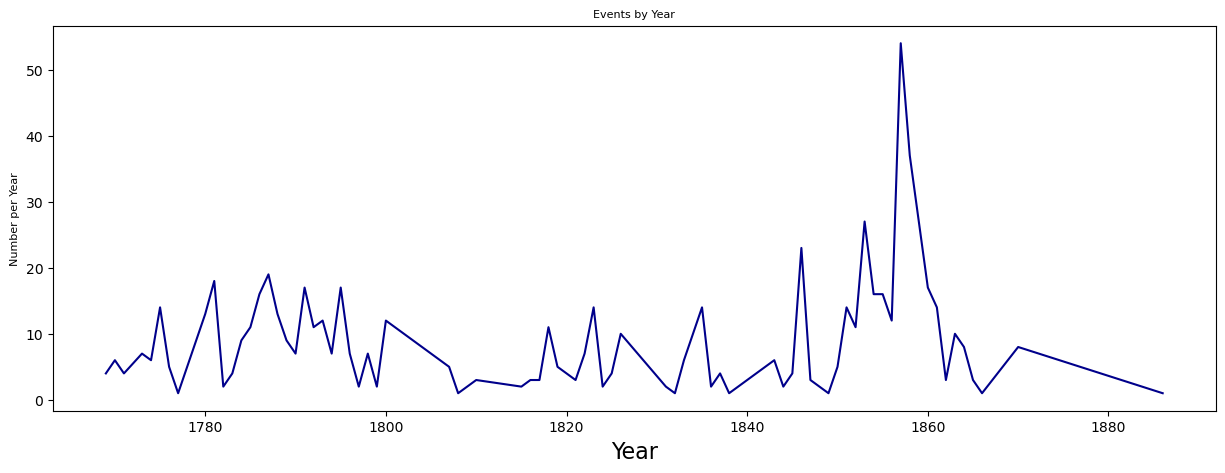

In [136]:
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(111)

ax1.plot(events['Events'],color='darkblue')
plt.title('Events by Year', fontsize=8)
plt.ylabel('Number per Year', fontsize=8)
plt.xlabel('Year', fontsize=16)
#plt.xticks(np.arange(1750, 1870, 20))
#plt.annotate('1862', (1862,90), fontsize=12)

# Save final file to CSV. Drop the 'Year' Column

In [137]:
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','lat','long','Status','Enslaver ID','Date','Description','Overseers','Source Description','Page','Repository']]
enslaved.head(2)

,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Description,Overseers,Source Description,Page,Repository
0,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
1,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",39.925937,-75.169597,Free,NaN,1850-08-15,"Dwelling 633, Family 839, Banks Family. Rebecc...",NaN,"Pennsylvania, Moyamensing Ward 3, Philadelphia...",381B,Ancestry.com ( http://www.ancestry.com : 2009)


In [138]:
#enslaved['Spouses'] = enslaved['Spouses'].replace(to_replace=' ', value=np.NaN)
#enslaved['Children'] = enslaved['Children'].replace(to_replace='       ', value=np.NaN)
enslaved.isnull().sum()


Person                   0
Given Name               0
Alternate Name        2785
Surname               2327
Sex                      0
RN                       0
Birth date               2
Death date            2853
Father                2493
Mother                2230
Spouses               2179
Children              2257
Event ID                90
Event Type              90
Place                   90
lat                    131
long                   131
Status                   0
Enslaver ID            127
Date                    90
Description             90
Overseers              799
Source Description    1063
Page                  1684
Repository            1063
dtype: int64

In [139]:
Persons = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children']]
print(Persons.shape)
Persons = Persons.drop_duplicates()
print(Persons.shape)
Persons.head()

(3099, 12)
(705, 12)


,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children
0,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN
1,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN
2,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN
3,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN
4,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,NaN,NaN,PERS-CAB-308-UH,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...


In [140]:
Persons.isnull().sum()

Person              0
Given Name          0
Alternate Name    645
Surname           490
Sex                 0
RN                  0
Birth date          2
Death date        600
Father            547
Mother            491
Spouses           539
Children          600
dtype: int64

In [141]:
enslaved[enslaved['Given Name']=='Unknown'].nunique()

Person                34
Given Name             1
Alternate Name        28
Surname                1
Sex                    3
RN                    34
Birth date            33
Death date             2
Father                 7
Mother                23
Spouses                0
Children               0
Event ID              39
Event Type             4
Place                  4
lat                    4
long                   4
Status                 1
Enslaver ID            6
Date                  52
Description           37
Overseers              5
Source Description     9
Page                  29
Repository             2
dtype: int64

In [142]:
enslaved[enslaved['Sex']=='?'].nunique()

Person                13
Given Name             8
Alternate Name         2
Surname                1
Sex                    1
RN                    13
Birth date            10
Death date             2
Father                 3
Mother                 7
Spouses                0
Children               0
Event ID              19
Event Type             9
Place                  5
lat                    5
long                   5
Status                 1
Enslaver ID            7
Date                  18
Description           19
Overseers              5
Source Description     7
Page                   6
Repository             4
dtype: int64

In [143]:
Events = enslaved[['Event ID','lat','long','Overseers','Source Description','Page','Repository']]
print(Events.shape)
Events = Events.drop_duplicates()
print(Events.shape)

(3099, 7)
(606, 7)


In [144]:
Events[Events['Event ID'].isnull()]

,Event ID,lat,long,Overseers,Source Description,Page,Repository
3009,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
Events = Events.dropna(subset=['Event ID'])
print(Events.shape)

(605, 7)


In [146]:
Events.isnull().sum()

Event ID                0
lat                    19
long                   19
Overseers             125
Source Description    122
Page                  263
Repository            122
dtype: int64

In [147]:
Events['Event ID'].nunique()

593

In [148]:
Events['Event ID'].value_counts().head(10)

Event ID
EVE-RES-011    3
EVE-TFR-032    3
EVE-OVR-001    2
EVE-DEA-009    2
EVE-BIR-020    2
EVE-TRV-051    2
EVE-ENS-017    2
EVE-OVR-002    2
EVE-ENS-008    2
EVE-CEN-001    2
Name: count, dtype: int64

In [149]:
Events.isnull().sum()

Event ID                0
lat                    19
long                   19
Overseers             125
Source Description    122
Page                  263
Repository            122
dtype: int64

In [150]:
Events[Events['Event ID']=='EVE-ENS-008']

,Event ID,lat,long,Overseers,Source Description,Page,Repository
501,EVE-ENS-008,37.642500,-78.731389,PERS-CAB-531-UH,NaN,NaN,NaN
616,EVE-ENS-008,37.643022,-78.759961,PERS-CAB-531-UH,NaN,NaN,NaN


### Enslaver Person data does not have events associated with it

In [151]:
enslaved.head(5)

,Person,Given Name,Alternate Name,Surname,Sex,RN,Birth date,Death date,Father,Mother,Spouses,Children,Event ID,Event Type,Place,lat,long,Status,Enslaver ID,Date,Description,Overseers,Source Description,Page,Repository
0,PERS-CAB-1075-UH,Henry,NaN,Banks,M,1075,1820,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
1,PERS-CAB-1071-UH,Lavinia,Laura,Banks,F,1071,1832,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-CEN-009,Census,"Philadelphia, Pennsylvania",39.925937,-75.169597,Free,NaN,1850-08-15,"Dwelling 633, Family 839, Banks Family. Rebecc...",NaN,"Pennsylvania, Moyamensing Ward 3, Philadelphia...",381B,Ancestry.com ( http://www.ancestry.com : 2009)
2,PERS-CAB-1074-UH,Daniel,NaN,Banks,M,1074,1837,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
3,PERS-CAB-1073-UH,Charlotte,NaN,Banks,F,1073,1836,NaN,PERS-CAB-1065-UH,PERS-CAB-1067-UH,NaN,NaN,EVE-EMN-001,Emancipation,Soldier's Joy,37.642500,-78.731389,Free,NaN,1845-08-10,"Freed upon death of enslaver, Daniel Higginbot...",NaN,"Higginbotham, Daniel.Will of Daniel Higginboth...",NaN,"Nelson County Circuit Court, Lovingston, Va."
4,PERS-CAB-948-UH,Beverly,NaN,Hartgrove,M,948,bef 1820,NaN,NaN,NaN,PERS-CAB-308-UH,PERS-CAB-788-UH PERS-CAB-791-UH PERS-CAB-794-U...,EVE-RES-032,Residence,"Washington, DC",38.906445,-77.036548,Free,NaN,1866-11-24,"Opened Bank account in Washington, D.C Account...",NaN,Records of the Field Offices for the State of ...,NaN,Ancestry.com (http://ancestry.com : 19 Jan 2024)


In [152]:
enslaved.to_csv("UHEnslavedFullExport.csv", sep = '\t')

# COMPLETE